# Get required resources
The purpose of this script is to check on the downloaded and regridded CMIP5 data. To start I am going to focus on Precip, temperature, and relatice humidity. 

## TODO:
- Make Pandas dataframe summaries of regional grid boxes, such that you have a dataframe for a given variable and can have each models (columns) monthly (rows) output in one convienent place. 

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import numpy as np
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
import os
import pandas as pd # TODO: Lots of training
import ../Python_scripts/model_dictionary as md # md, you know, like the helpful kind of doctor

ImportError: No module named model_dictionary

Deal with gray borders

In [82]:
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

### loading monthly nc data function
The function get_nc_vals() is being developed to load and return monthly nc data for a specified variable, model, and rcp scenario. Right now, functionality is limited to loading merged data (200601-210012) on a common grid. The data were merged and regridded using CDO commands. See the data directory README for more detials.  

ake a super simple plot of global mean monthly temperature vs. time for the 21st century for a given model, one from RCP4.5 and one from RCP8.5. Note that all comparisons will be done using the CMIP5 nc files that share a common grid. 

I finally figured out a nice way to subset 3D python arrays. 
https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices

Also, should probably look into the slicing abilities of xarray

In [55]:
def get_nc_vals(var="tas", rcp="45", model="ACCESS1-0", minLon=0., maxLon=360., minLat=-90., maxLat=90.):
    """This function will be for loading a particular nc file, which will be spatially subset"""
    
    # Create link to the monthly file
    # TODO: Make dataDir a dynamic global variable
    dataDir = 'r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID'
    f = var + "_" + "Amon_" + model + "_rcp" + rcp + "_r1i1p1_200601-210012.nc"
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 1140):
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("2006-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1140 expected.")
        
        
    # Now subset the data based on the passed max and min values for lon and lat
    lonIndex = np.where( ((lon >= minLon) & (lon <= maxLon)) )[0]
    latIndex = np.where( ( (lat >= minLat) & (lat <= maxLat) ) )[0]
    timeIndex = range(0, len(t)) # because we want all months, for now

    # Subset the 2D field
    lonCut = lon[lonIndex]
    latCut = lat[latIndex]

    # Subset the 3D field
    valsCut = vals[np.ix_(timeIndex, latIndex, lonIndex)]

    return valsCut, t_mon, lonCut, latCut

In [56]:
# This is how to see if a file exists
os.path.isfile('r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID/tas_Amon_CMCC-CESM_rcp45_r1i1p1_200601-210012.nc')

False

## Load nc data from two different scenarios, ensure they are on the same grid, plot monthly values

Unique differences in time array: [0]
Unique differences in longitude: [0.]
Unique differences in latitude: [0.]


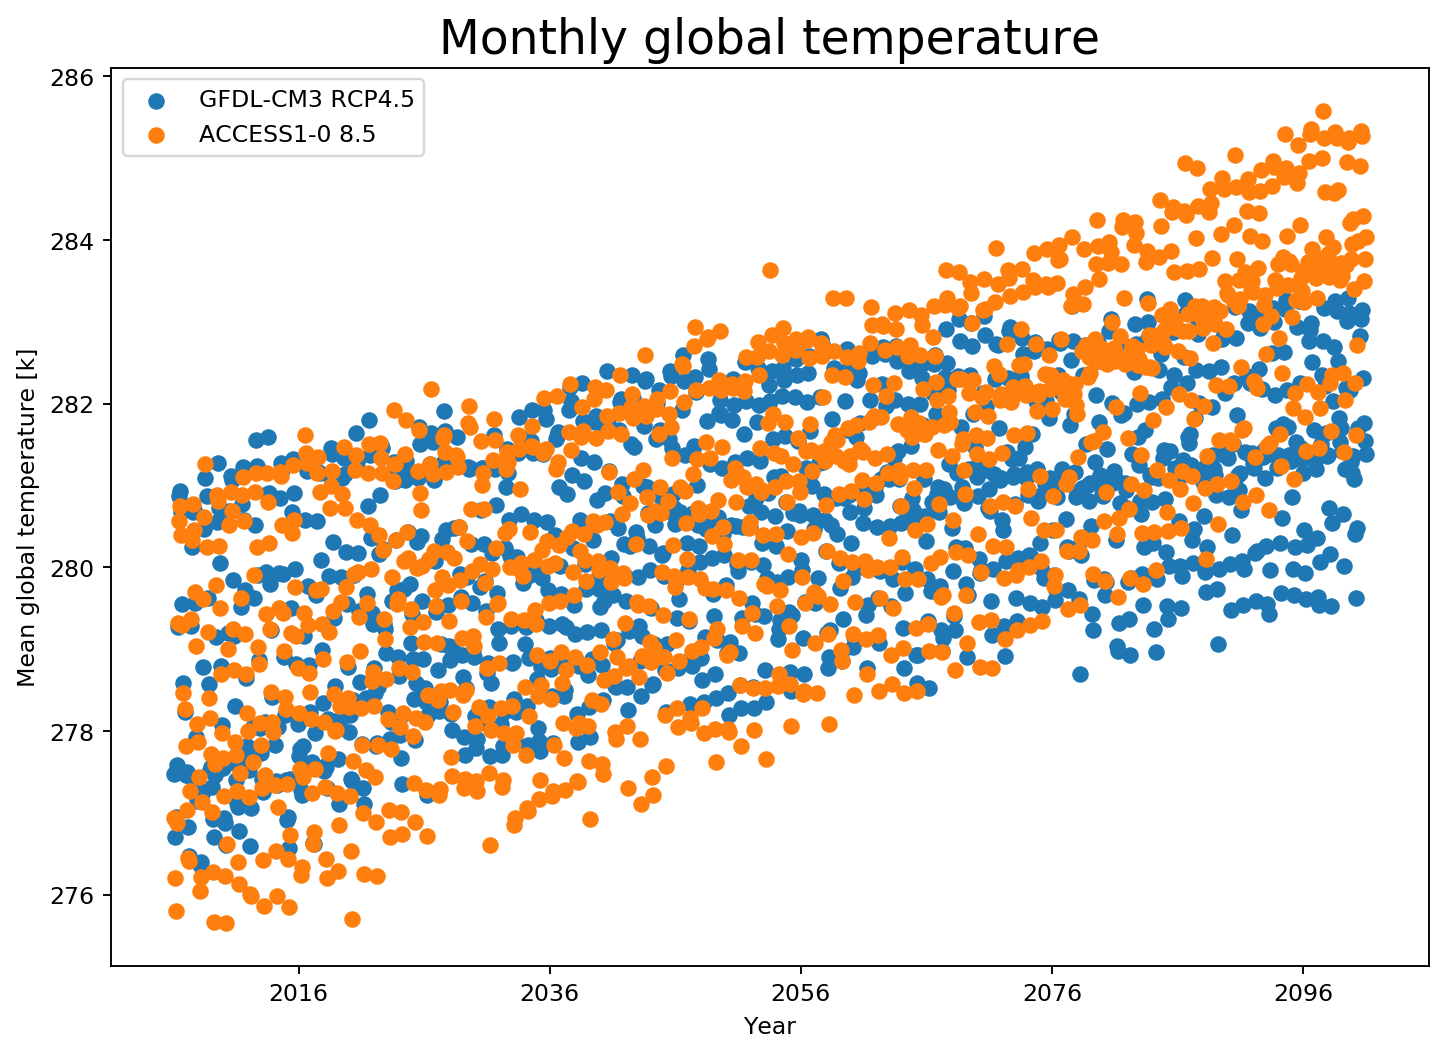

In [57]:
# Get an rcp45 temperature
tas45,t45,lon45,lat45 = get_nc_vals("tas","45","GFDL-CM3") # get contents of the nc file

# Get an rcp85 temperature
tas85,t85,lon85,lat85 = get_nc_vals("tas","85","ACCESS1-0") # get contents of the nc file

dt = np.unique(t85 - t45)
dlon = np.unique(lon85 - lon45)
dlat = np.unique(lat85 - lat45)
print 'Unique differences in time array: ' + str(dt)
print 'Unique differences in longitude: ' + str(dlon)
print 'Unique differences in latitude: ' + str(dlat)

# consolidate coordinates 
lon = lon45
lat = lat45
t = t45

#if (dlat == 0 and dlon == 0 and dt == 0):
#    print "Dimensions of data agree!"
#else:
#    raise ValueError("Different dimensions detected in data.")

# Calculate global monthly temperature for the two datasets
monthly_means_45 = np.mean(tas45, axis=(1,2))
monthly_means_85 = np.mean(tas85, axis=(1,2))

plt.figure(figsize=(10,7), dpi=170)
plt.scatter(t45, monthly_means_45, label="GFDL-CM3 RCP4.5")
plt.scatter(t85, monthly_means_85, label="ACCESS1-0 8.5")
plt.xlabel("Year")
plt.ylabel("Mean global temperature [k]")
plt.title("Monthly global temperature", fontsize=20)
plt.legend()
plt.show()

It looks like there is a LOT of spread within a short time span, e.g. from 2006 to 2016. Surely this is relfecting the fact that there are monthls that are warmer than others, globally. Show the temperature time series for a single year. 

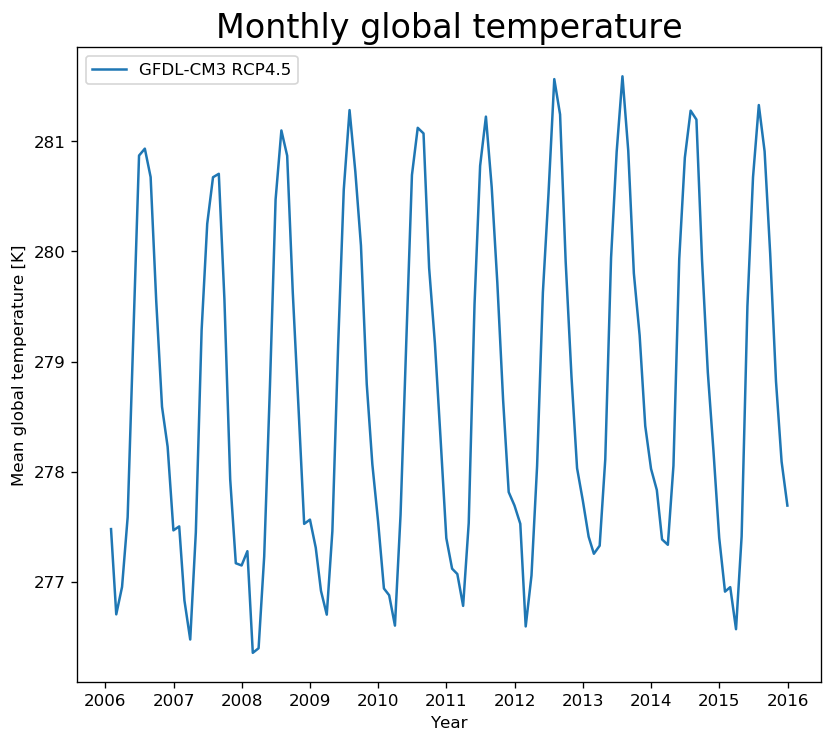

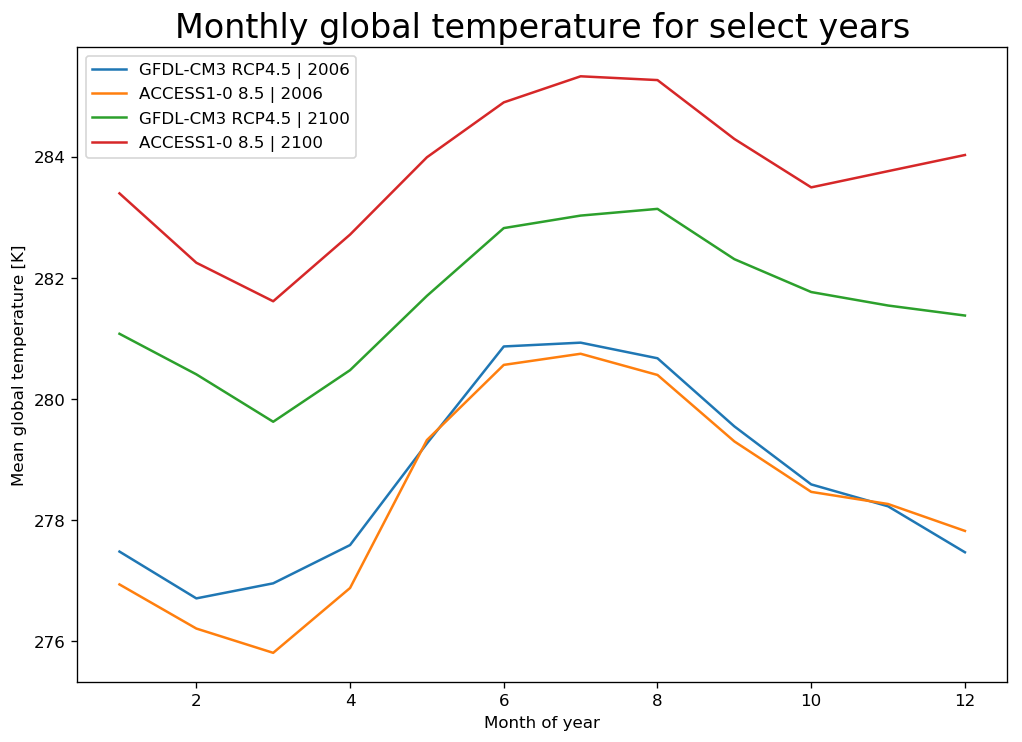

In [58]:
decadeIndex = range(12*10)

plt.figure(figsize=(8,7), dpi=120)
plt.plot(t45[decadeIndex], monthly_means_45[decadeIndex], label="GFDL-CM3 RCP4.5")
#plt.scatter(t85[decadeIndex], monthly_means_85[decadeIndex], label="ACCESS1-0 8.5")
plt.xlabel("Year")
plt.ylabel("Mean global temperature [K]")
plt.title("Monthly global temperature", fontsize=20)
plt.legend()
plt.show()

yearIndex = range(12)
months = np.arange(1,13)

plt.figure(figsize=(10,7), dpi=120)
plt.plot(months, monthly_means_45[yearIndex], label="GFDL-CM3 RCP4.5 | 2006")
plt.plot(months, monthly_means_85[yearIndex], label="ACCESS1-0 8.5 | 2006")
plt.plot(months, monthly_means_45[1128:1140], label="GFDL-CM3 RCP4.5 | 2100")
plt.plot(months, monthly_means_85[1128:1140], label="ACCESS1-0 8.5 | 2100")
plt.xlabel("Month of year")
plt.ylabel("Mean global temperature [K]")
plt.title("Monthly global temperature for select years", fontsize=20)
plt.legend()
plt.show()



The second figure in the last section seems to check out. 
* The two models for RCP 4.5 and 8.5 are cooler for all months in the year 2006 than the yaer 2100. 
* The models are in good agreement for the year 2006. In 2100, when the scenario should start to make a big difference, we do see a difference. 
* In 2100 RCP8.5 is about 4 degrees warmer than RCP4.5
* #### are the two models that start in 2006 supposed to have the same starting temperature? Is that not the point of using a common ensemble member? I thought they had the same initial condition? 

## Load Western US nc data from two different scenarios, ensure they are on the same grid, plot monthly values

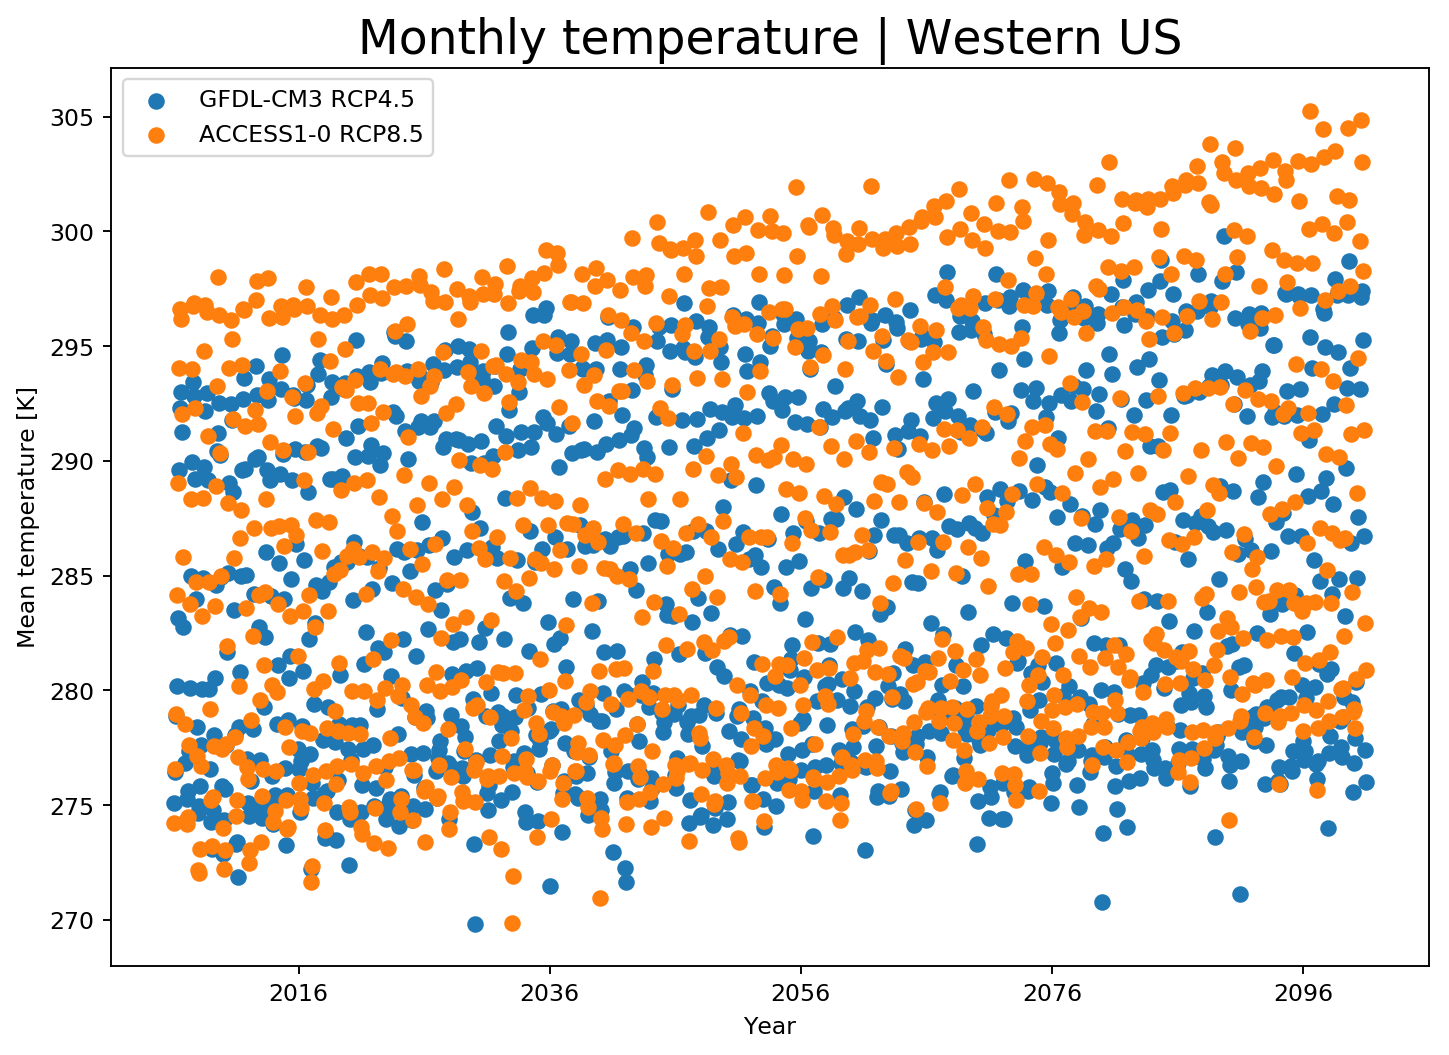

In [59]:
# The following lat-lon limits represent a decent representation of the 11 Western US states. 
minLon = 235. # ~A bit west of Cape Alava in Washington State, so this gets you all of CONUS.   
maxLon = 258. # ~Aligns with the eastern border of Colorado
minLat = 31. # ~Latitude of the Western side of the New Mexico Mexico border 
maxLat = 49.  # ~Latitude of the US northern border with Canada  

# Get an rcp45 temperature for western US
tas45_west,t_west,lon_west,lat_west = get_nc_vals("tas","45","GFDL-CM3", minLon, maxLon, minLat, maxLat)

# Get an rcp85 temperature for western US
tas85_west,t_west,lon_west,lat_west = get_nc_vals("tas","85","ACCESS1-0", minLon, maxLon, minLat, maxLat) 

# Calculate global monthly temperature for the two datasets
monthly_means_45 = np.mean(tas45_west, axis=(1,2))
monthly_means_85 = np.mean(tas85_west, axis=(1,2))

plt.figure(figsize=(10,7), dpi=170)
plt.scatter(t45, monthly_means_45, label="GFDL-CM3 RCP4.5")
plt.scatter(t85, monthly_means_85, label="ACCESS1-0 RCP8.5")
plt.xlabel("Year")
plt.ylabel("Mean temperature [K]")
plt.title("Monthly temperature | Western US", fontsize=20)
plt.legend()
plt.show()

### I want to see what the first year and last year looks like for these randomly selected models. 

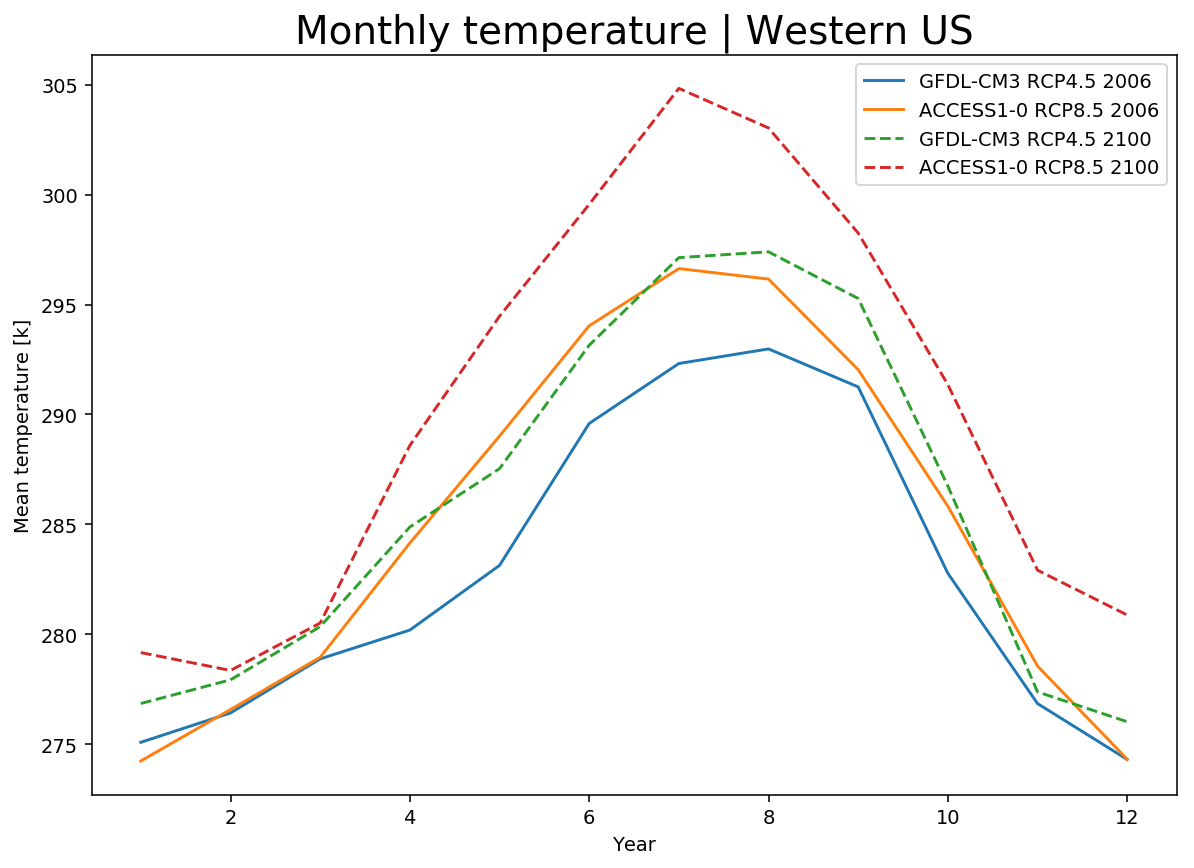

In [60]:
plt.figure(figsize=(10,7), dpi=140)
plt.plot(months, monthly_means_45[yearIndex], label="GFDL-CM3 RCP4.5 2006")
plt.plot(months, monthly_means_85[yearIndex], label="ACCESS1-0 RCP8.5 2006")
plt.plot(months, monthly_means_45[1128:1140], label="GFDL-CM3 RCP4.5 2100", linestyle="--")
plt.plot(months, monthly_means_85[1128:1140], label="ACCESS1-0 RCP8.5 2100", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Mean temperature [k]")
plt.title("Monthly temperature | Western US", fontsize=20)
plt.legend()
plt.show()

### Create a spatial display of global temperature using cartopy
OK, it looks like basemap is dead. Time for my work to reflect this reality. Here I go with testing simple spatial plotting using cartopy instead.
https://matplotlib.org/basemap/users/intro.html#cartopy-new-management-and-eol-announcement

In [61]:
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point # For plotting around lon=0

import shapely.geometry as sgeom 
import cartopy.io.shapereader as shpreader


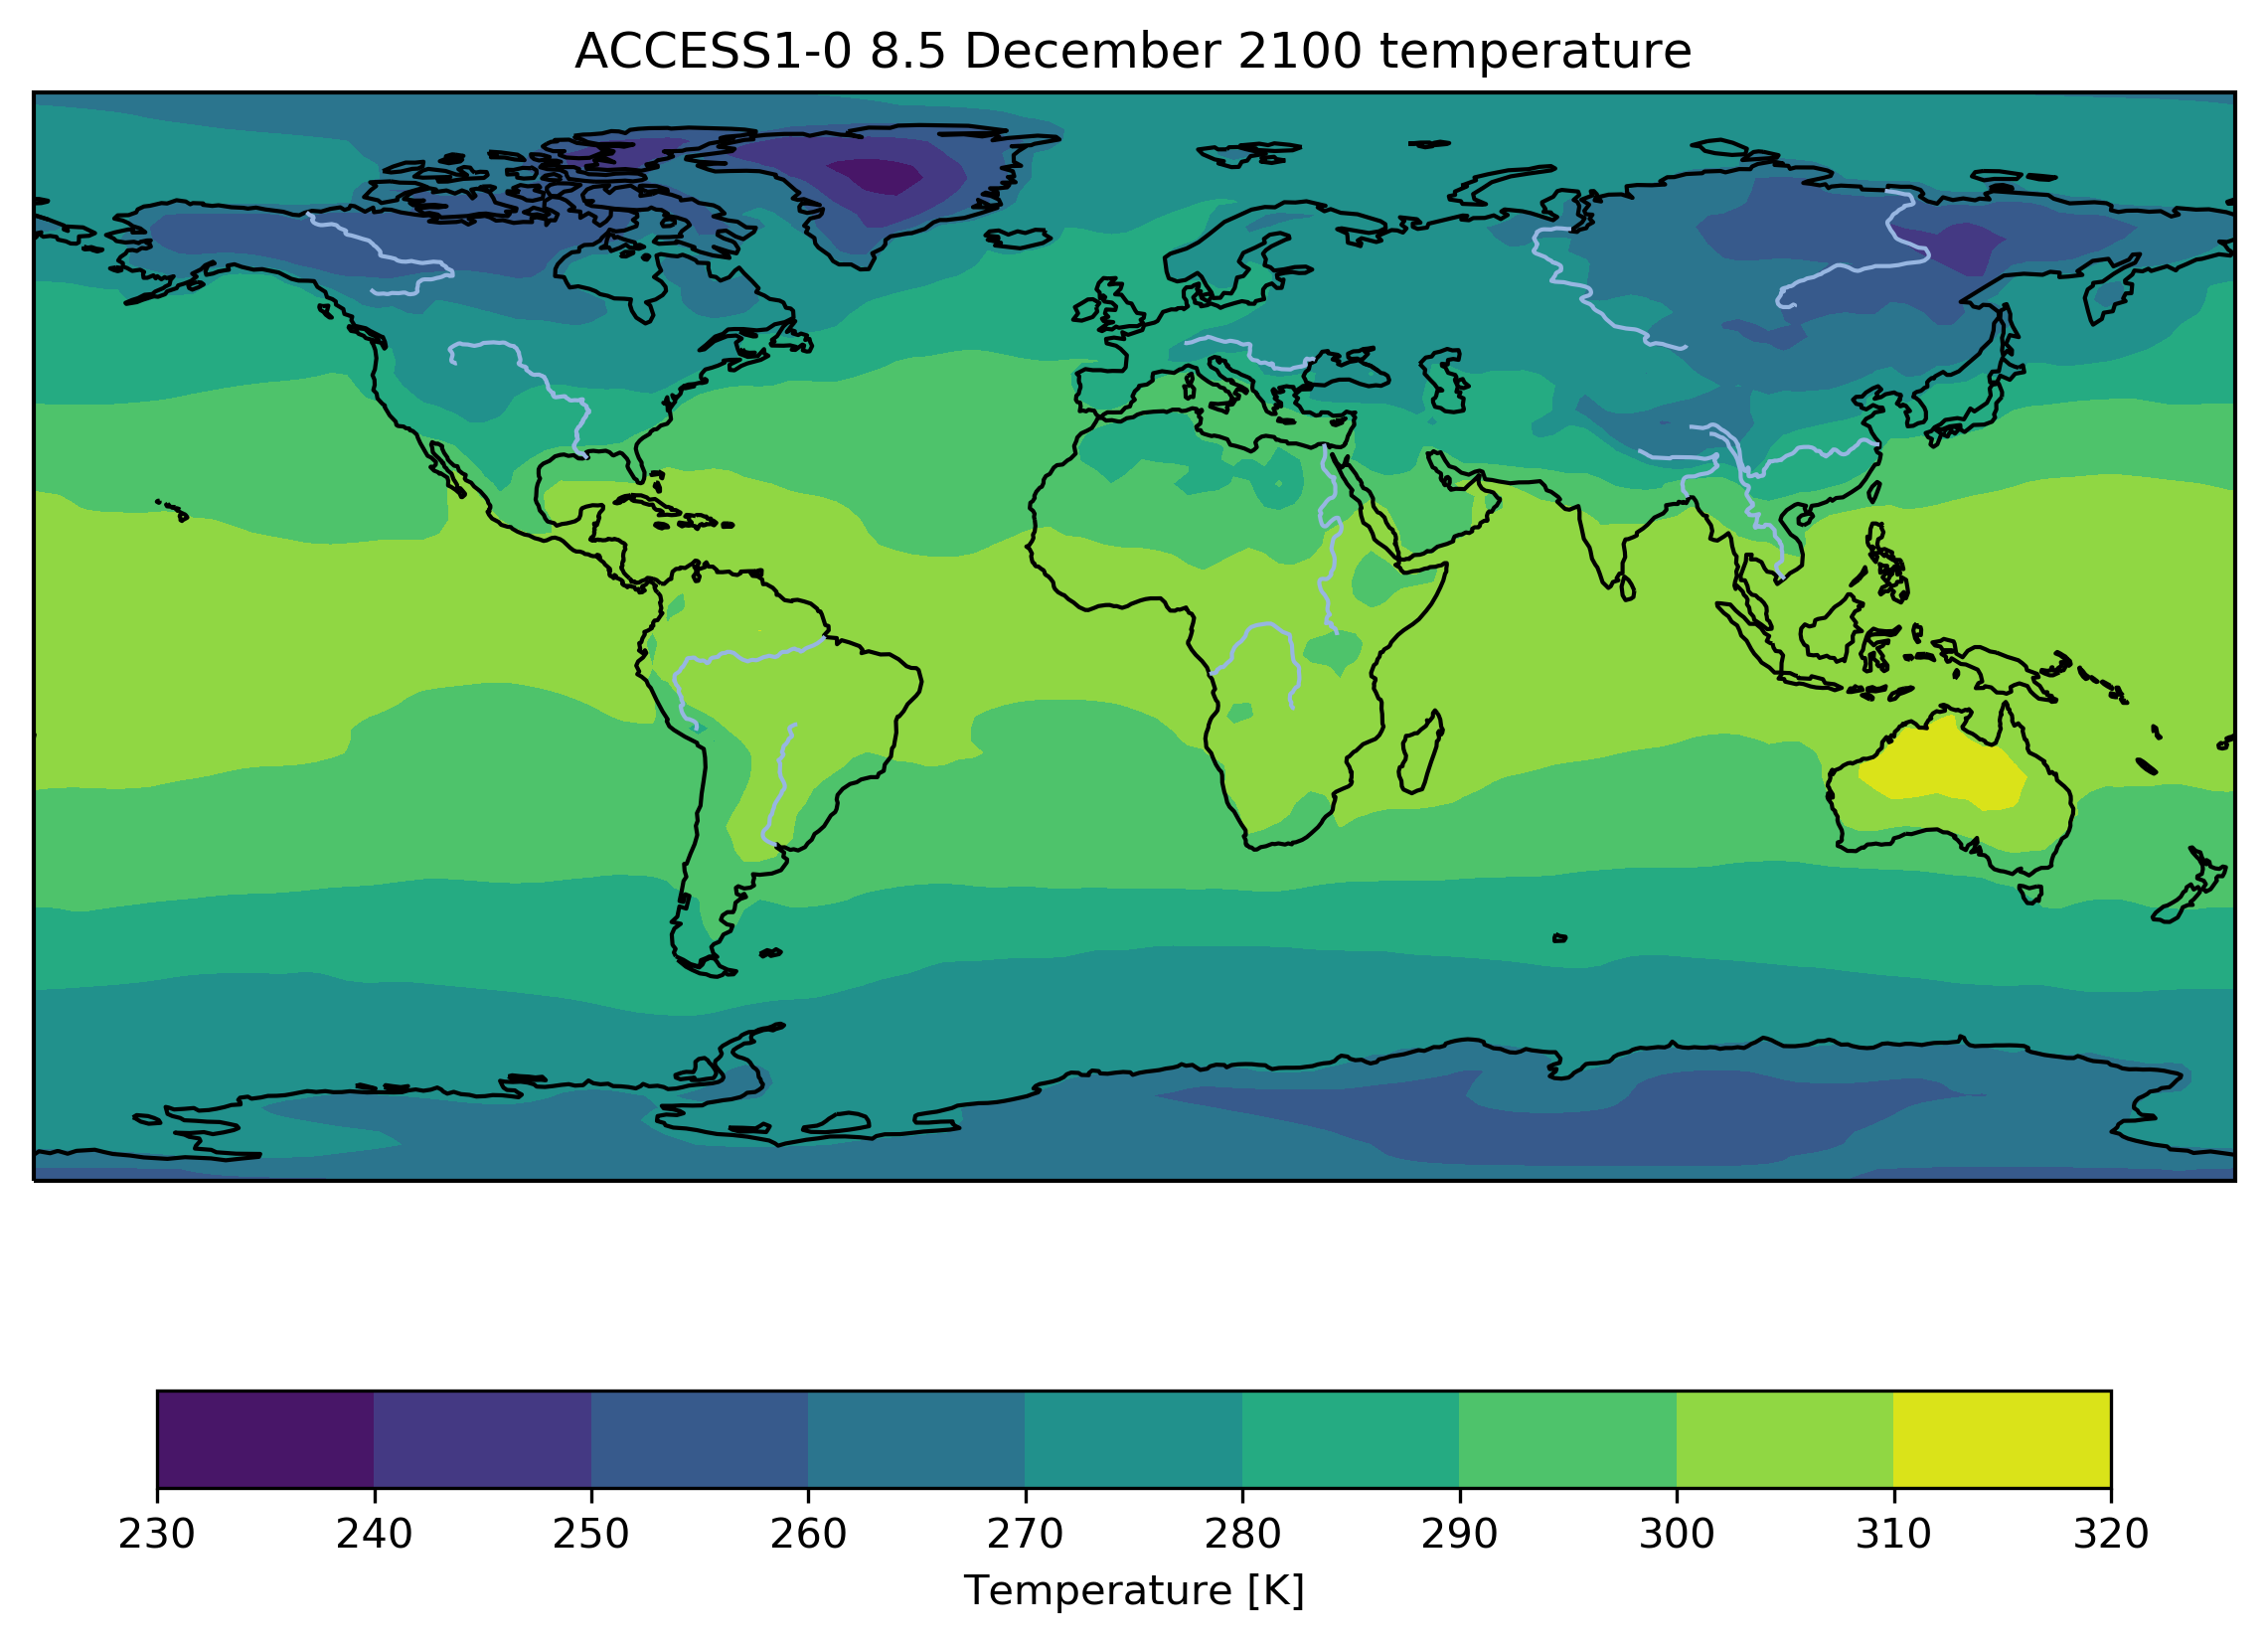

In [62]:
# problem: white line at 0-degrees lon, use addcyclic
# wrapping data solution for contourf: https://gist.github.com/darothen/c7560d8d19ffca90024c1f2df4927599
wrap_data_85, wrap_lon = add_cyclic_point(tas85[-1,:,:], coord=lon45)
wrap_data_45, wrap_lon = add_cyclic_point(tas45[-1,:,:], coord=lon45)

plt.figure(figsize=(13,6.2))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(wrap_lon, lat45, wrap_data_85,
             transform=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.RIVERS)
plt.title("ACCESS1-0 8.5 December 2100 temperature")
plt.colorbar(orientation="horizontal", fraction=0.07, label="Temperature [K]")
plt.show()

* Plot is showing December 2100 mean monthly near surface temperature. 
* It is colder in the northern hemisphere than in the southern hemisphere. Yay! 
* The tropics are warm. Yay! 
* Contours look sensible! This does not make me suspect anything funky happened when merging and regridding the data using CDO commands. 


### Show a map of western US temperature only. Use this area to figure out bounds for different US regions. 

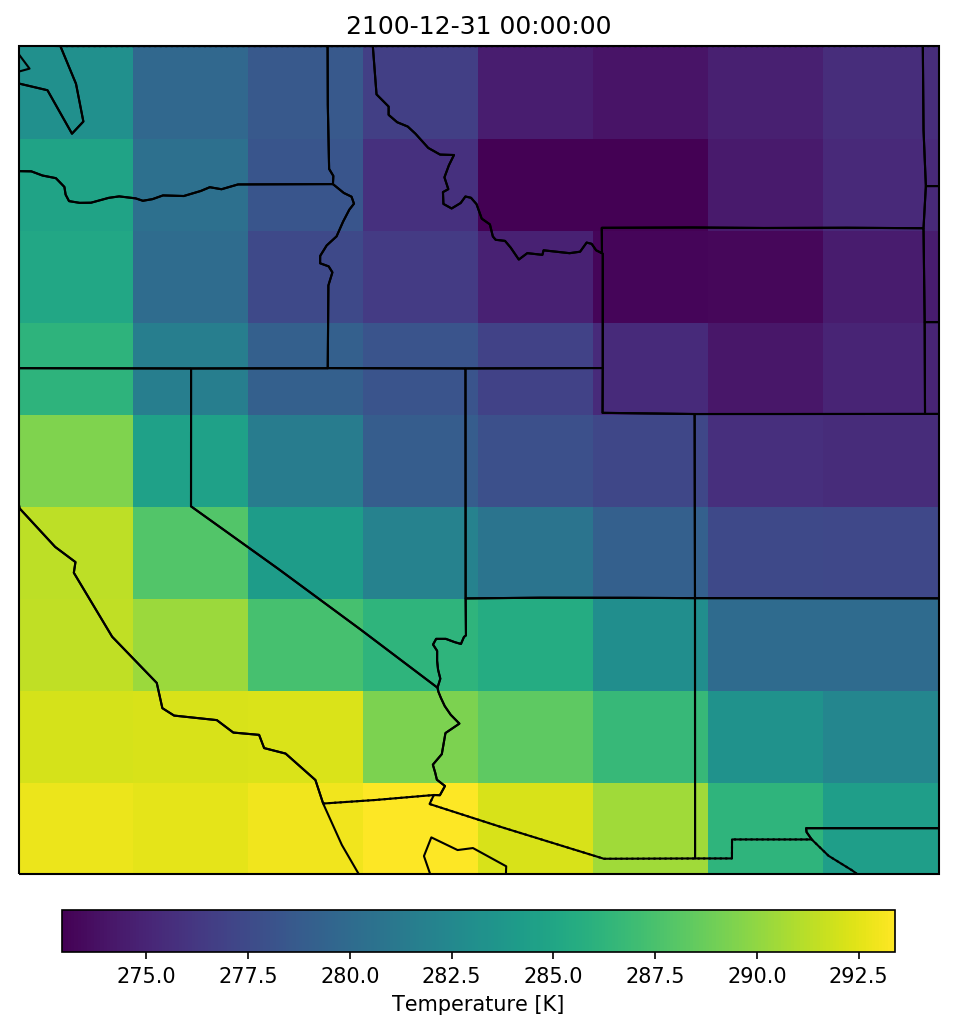

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def contourf_plot(x, y, z, titleText, label):
    """Code to make a single plan view plot of nc data using plt.pcolor. Mapping
    is handled using cartopy. Additional arguments will follow. This is a quick
    version that enables me to see the data quickly, not make a super nice plot."""

    # First I want to read US states shapefile for plotting western US states
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
    state = shpreader.Reader(states_shp).geometries()

    minLon = np.min(x); maxLon = np.max(x)
    minLat = np.min(y); maxLat = np.max(y)
    
    plt.figure(figsize=(10,8), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.pcolor(x, y, z, transform=ccrs.PlateCarree())
    ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree())
    ax.add_geometries(state, ccrs.PlateCarree(), facecolor="none", edgecolor="k")
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    #ax.add_feature(cartopy.feature.RIVERS)
    #ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    plt.title(titleText)
    plt.colorbar(fraction=0.046, pad=0.04, label=label, orientation="horizontal")
    plt.show()

# Plot December 2100 temperature
contourf_plot(lon_west, lat_west, tas85_west[-1,:,:], t[-1], "Temperature [K]") 

### Questions to consider regarding this plot 
* Is a general gradient of warmer temperatures in the southwest over the ocean and cooler temperatures to the northeast interior generally realistic? 
* The Rockies do not really seem to show much of an influence here, however, this is only one month of data. Is this sensible? What are climate models capable of? 

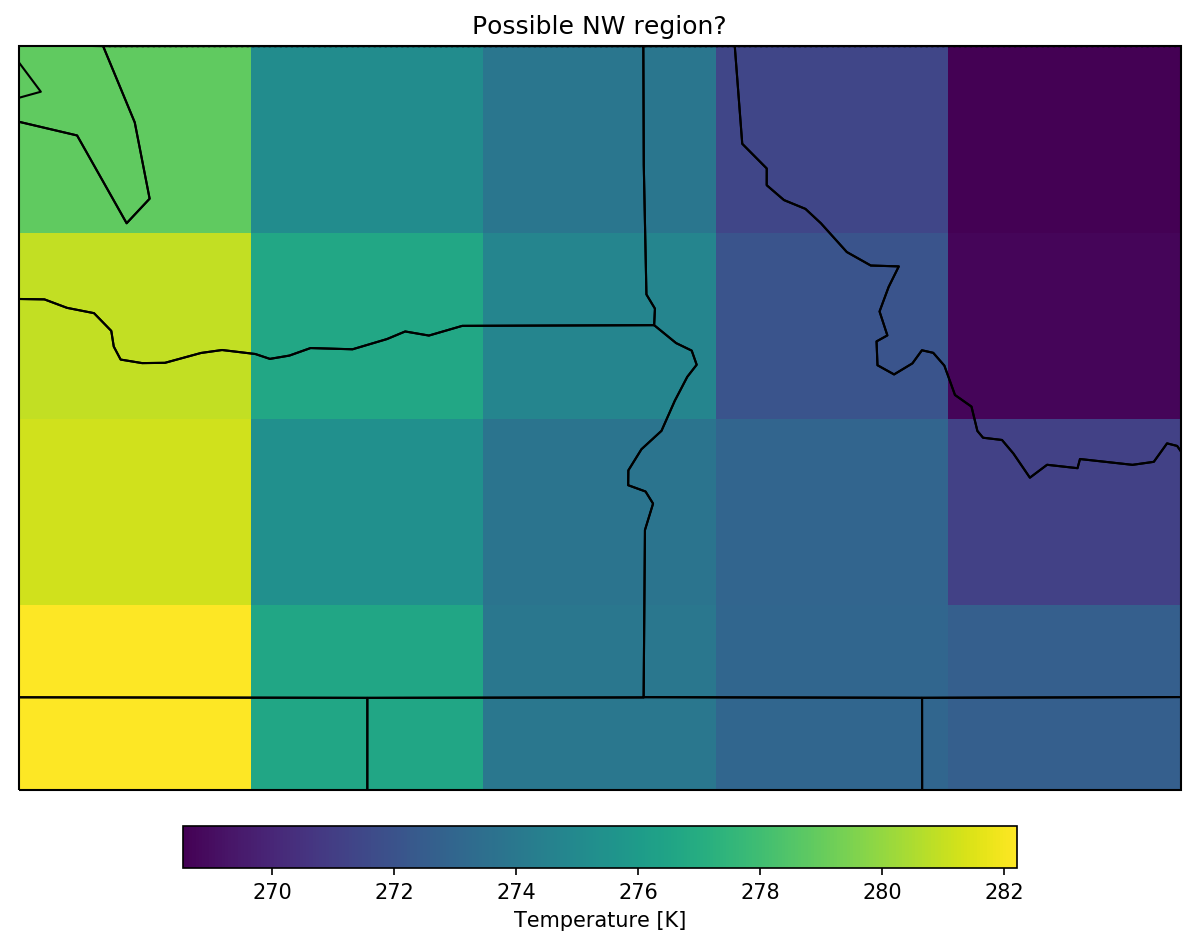

In [64]:
minLon = 235. # ~A bit west of Cape Alava in Washington State, so this gets you all of CONUS.   
maxLon = 258. # ~Aligns with the eastern border of Colorado
minLat = 31. # ~Latitude of the Western side of the New Mexico Mexico border 
maxLat = 49.  # ~Latitude of the US northern border with Canada  

z, t_temp, x, y = get_nc_vals("tas","45","GFDL-CM3", minLon=236, maxLon=250, minLat=40, maxLat=50)
contourf_plot(x, y, z[-1,:,:], "Possible NW region?", "Temperature [K]") 

This region seems like a possible candidate for a subregion, aka, a PNW region. Enough grid boxes? Too big? Too small? 

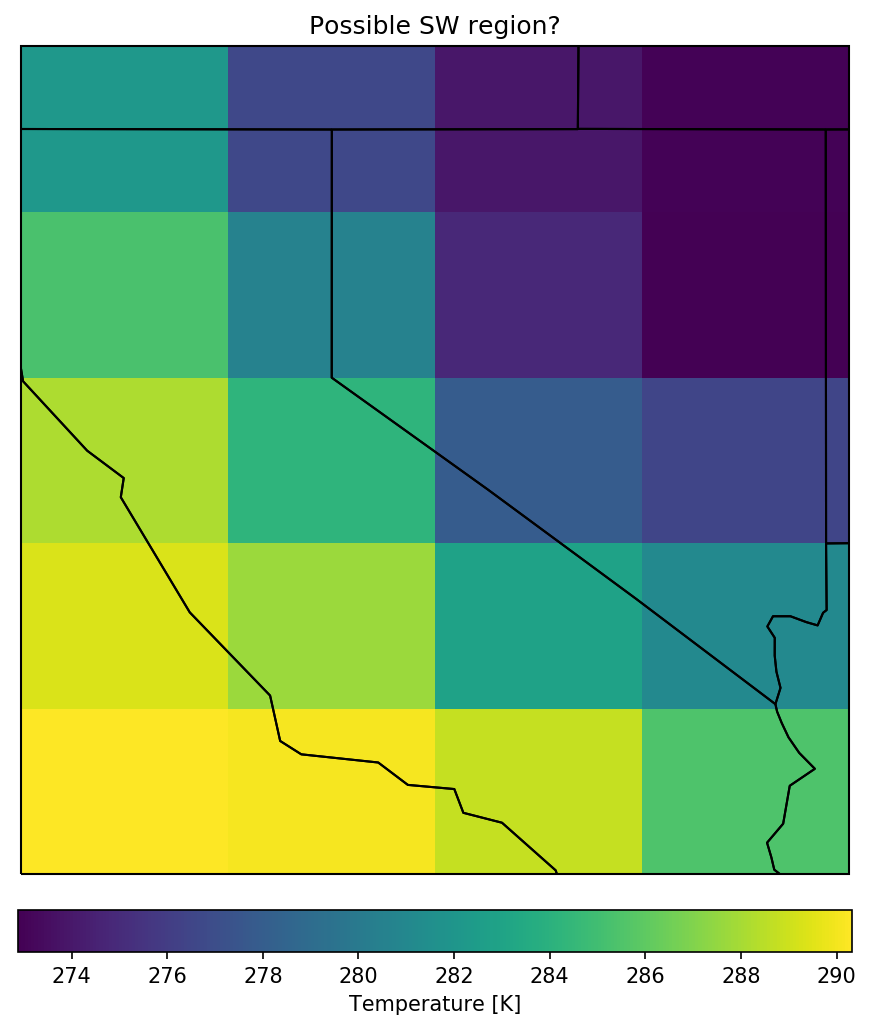

In [65]:
z, t_temp, x, y = get_nc_vals("tas","45","GFDL-CM3", minLon=236, maxLon=248, minLat=32, maxLat=43)
contourf_plot(x, y, z[-1,:,:], "Possible SW region?", "Temperature [K]") 

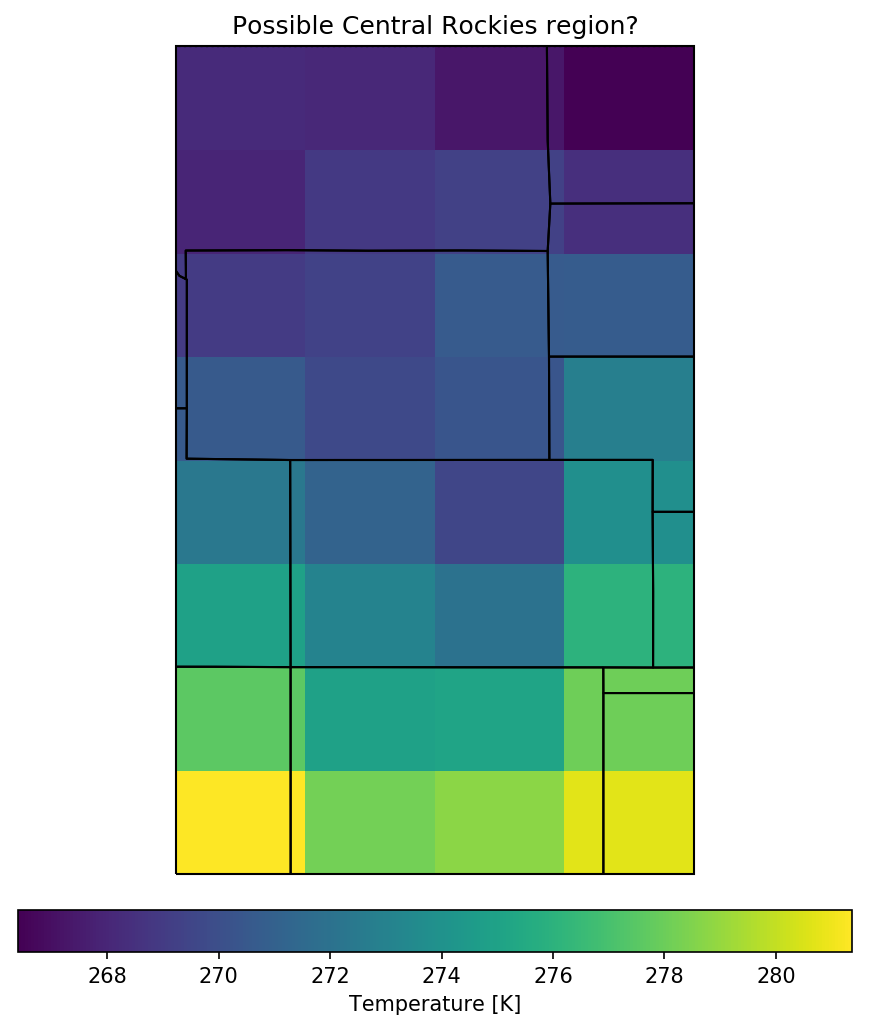

In [66]:
z, t_temp, x, y = get_nc_vals("tas","45","GFDL-CM3", minLon=248, maxLon=260, minLat=32, maxLat=50)
contourf_plot(x, y, z[-1,:,:], "Possible Central Rockies region?", "Temperature [K]") 

These look like reasonable bounds to start working with. Create a quick dictionary to store these coordinates in. 

In [67]:
regions = {}
regions["Western US"] = [235., 258., 31., 49.]
regions["Northwest"] = [236., 250., 40., 50.]
regions["Southwest"] = [236., 248., 32., 43.]
regions["Central Rockies"] = [248., 260., 32., 50.]
print regions["Western US"]

[235.0, 258.0, 31.0, 49.0]


### Lets take a quick look at precipitation and its pesky units. 

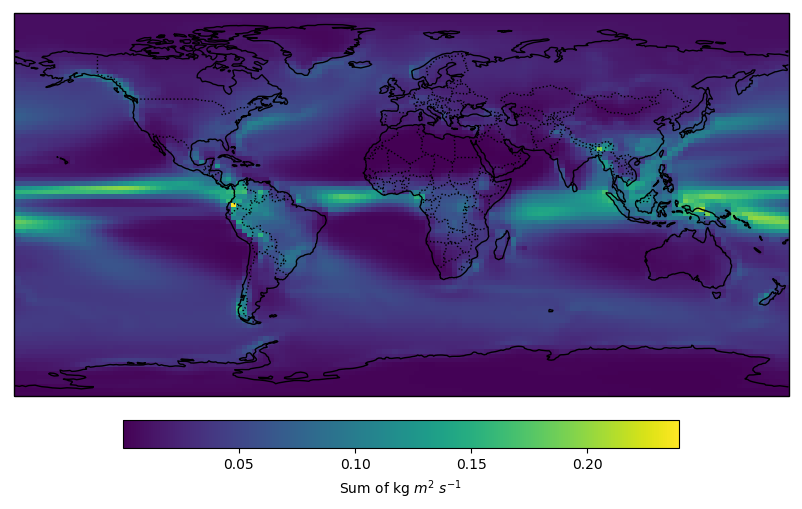

In [68]:
pr45,t45,lon45,lat45 = get_nc_vals("pr","45","ACCESS1-0")
pr85,t85,lon85,lat485 = get_nc_vals("pr","85","ACCESS1-0")

# NOTE: Precip units of kg / m**2 / s make for VERY small numbers

# These units mandate that we know the number of days in the time period to calculate 
# total rainfall amounts... This is a pain because different models have different 
# Calendars. For now, I will not touch these units. 
total45 = np.sum(pr45, axis=0)
wrap_total45, wrap_lon = add_cyclic_point(total45, coord=lon45)


plt.figure(figsize=(10,8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolor(wrap_lon, lat45, wrap_total45,
             transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
plt.title("")

plt.colorbar(fraction=0.046, pad=0.04, label="Sum of kg $m^{2}$ $s^{-1}$", orientation="horizontal")
plt.show()


## Estimate vapor pressure deficit using relative humidity percent and temperature
### Currently only working for 1D array data.


Vapour-pressure deficit, or VPD, is the difference (deficit) between the amount of moisture in the air and how much moisture the air can hold when it is saturated.

The equation for below $e^{*}$, or saturation vapor pressure is an estimate using "tetons equation". According to Monteith and Unsworth, "Values of saturation vapour pressure from Tetens' formula are within 1 Pa of exact values up to 35 °C."

\begin{align}
VPD & = e^{*}-e \\
\\
e^{*}(T>0^{o}C) & = 0.6108\exp{\frac{17.27*T}{T+237.3}} \\
\\
e^{*}(T<0^{o}C) & = 0.6108\exp{\frac{21.875*T}{T+265.5}} \\
\\
e & = \frac{RH}{100} e^{*} \\
\end{align}


In [69]:
def calculate_VPD(RH, T):
    """Function for estimating Vapor Pressure Deficit (VPD) using near surface relative humidity and temperature.
        T = units of degrees C
        RH = relative humidity, 0-100
            returns: vpd (kPa), vapor pressure (kPa), saturation vapor pressure (kPa)
        TODO: Make this work with gridded data, not just 1D arrays! 
    """
    
    # Tetons equation used for estimates:
    # https://en.wikipedia.org/wiki/Tetens_equation
    
    es = np.zeros(len(T)); es[:]=np.nan # place for saturation vapor pressure to live
    T_C = T - 273.15 # convert to C from K
    
    aboveZero = T_C > 0. 
    belowZero = T_C <= 0.
    es[aboveZero] = 0.6108 * np.exp( (17.27 * T_C[aboveZero]) / (T_C[aboveZero] + 237.3) ) # kPa, saturation vapor pressure
    es[belowZero] = 0.61078 * np.exp( (21.875 * T_C[belowZero]) / (T_C[belowZero] + 265.5) )
    e  = RH / 100. * es # actual vapor pressure
    VPD = (es - e) # deficit, saturation vapor pressure - actual vapor pressure 
    
    return VPD, e, es

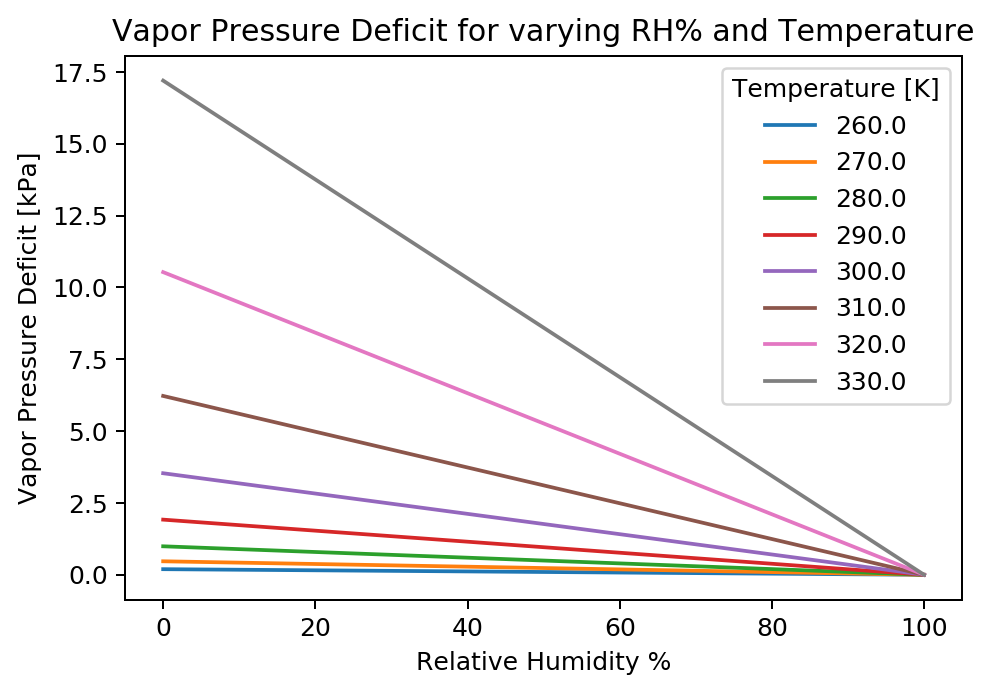

In [70]:
rh = np.linspace(0,100,100)
ts = np.linspace(260.,330,8)

plt.figure(dpi=180)
for i in ts:
    T = np.zeros(100); T[:] = i
    VPD, e, es = calculate_VPD(RH=rh, T=T)
    plt.plot(rh, VPD, label=i)

plt.xlabel("Relative Humidity %")
plt.ylabel("Vapor Pressure Deficit [kPa]")
plt.legend(title="Temperature [K]")
plt.title("Vapor Pressure Deficit for varying RH% and Temperature")
plt.show()

### VPD is very sensitive to temperature. 

# Transition to aggregating data using Pandas
### Plot all models monthly temperature over the western US. 

In [71]:
# create a pandas dataframe, of monthly temperature in the western US, for each model
# TODO: arguments will be RCP, variable, mean, sum, median, etc. because precipi will need something else. 
# TODO: handle bug in tas_Amon_HadGEM2-ES_rcp85_r1i1p1_200601-210012.nc. duplicate in time found at index 1127 1128
def make_var_df(var="tas", rcp="85", stat="mean", minLon=235., maxLon=258., minLat=31., maxLat=49.,
                regionName="null", regions="null", printError=False):
    """Make dataframe for a given variable. Defualt area is entire western US region. """
    
    # Was a region passed? If so use its bounds. 
    if (regionName != "null") & (regions != "null"):
        print "Using region dictionary for bounds"
        minLon = regions[regionName][0]
        maxLon = regions[regionName][1]
        minLat = regions[regionName][2]
        maxLat = regions[regionName][3]
    
    ncol = len(md.model_name.keys())
    nrow = 1140 # TODO: Make dynamic! 
    data = np.empty(shape=(nrow, ncol))
    df   = pd.DataFrame(data=data, columns=md.model_name.keys())

    # Populate this dataframe with real data
    for model in md.model_name.keys():
        #print model
        # TODO: reference a list that figures out if the file is supposed to exist.
        # TODO: do not throw an error for files that are not supposed to exist. 
        try:
            val,t,x,y = get_nc_vals(var, rcp, model, minLon, maxLon, minLat, maxLat)
            if stat=="mean":
                df[model] = np.mean(val, axis=(1,2))
            elif stat=="sum":
                df[model] = np.sum(val, axis=(1,2))
                
        except Exception as e:
            # Always place nan when the data do not exist or when there is an error
            df[model] = np.nan
            if printError:
                print("-------------------------------------------------------------------")
                print("There was an error here loading data for "+ model + " for rcp" + rcp)
                print(e)
                print("-------------------------------------------------------------------")
            
            
    
    # Label the rows, use time
    df.set_index(t)      
    
    # Add a mean
    df['mean'] = df.mean(axis=1)

    # Add atemporal labels 
    df['time'] = t
    df['year'] = t.year
    df['month'] = t.month
    
    print("---------------------------------------------")
    print(var + " Dataframe for rcp" + rcp + " complete.")
    print("---------------------------------------------")
    
    return df

## Create western US dataframes for downloaded variables.
This section of code is used to load the downloaded common grid variables and summarize them in the wester US. It will also allow me to see what dataframes are missing, and what ones are not formatted in the way that I expected. 


Do I even need to make a common grid when comparing spread for regions at varying spatial timescales? I do not think so. I think they only need to be on the same grid when I am doing spatial comparisons. 

In [72]:
# Near surface temperature
df_tas_85 = make_var_df(var="tas", rcp="85")
df_tas_45 = make_var_df(var="tas", rcp="45")
# Precipitation flux, kg / m**2 / s
df_pr_85 = make_var_df(var="pr", rcp="85", stat="sum")
df_pr_45 = make_var_df(var="pr", rcp="45", stat="sum")
    
# Near surface relative humidity
df_hurs_85 = make_var_df(var="hurs", rcp="85", stat="mean")
df_hurs_45 = make_var_df(var="hurs", rcp="45", stat="mean")

# Near surface windSpeed
# TODO: Handle missing data, etc, for sfcWind. Has not been done yet. 
df_sfcWind_85 = make_var_df(var="sfcWind", rcp="85", stat="mean")
df_sfcWind_45 = make_var_df(var="sfcWind", rcp="45", stat="mean")

---------------------------------------------
tas Dataframe for rcp85 complete.
---------------------------------------------
---------------------------------------------
tas Dataframe for rcp45 complete.
---------------------------------------------
---------------------------------------------
pr Dataframe for rcp85 complete.
---------------------------------------------
---------------------------------------------
pr Dataframe for rcp45 complete.
---------------------------------------------
---------------------------------------------
hurs Dataframe for rcp85 complete.
---------------------------------------------
---------------------------------------------
hurs Dataframe for rcp45 complete.
---------------------------------------------
---------------------------------------------
sfcWind Dataframe for rcp85 complete.
---------------------------------------------
---------------------------------------------
sfcWind Dataframe for rcp45 complete.
------------------------------

### Show the monthly temperature for all models and themean of all models as bigger dots for RCP8.5

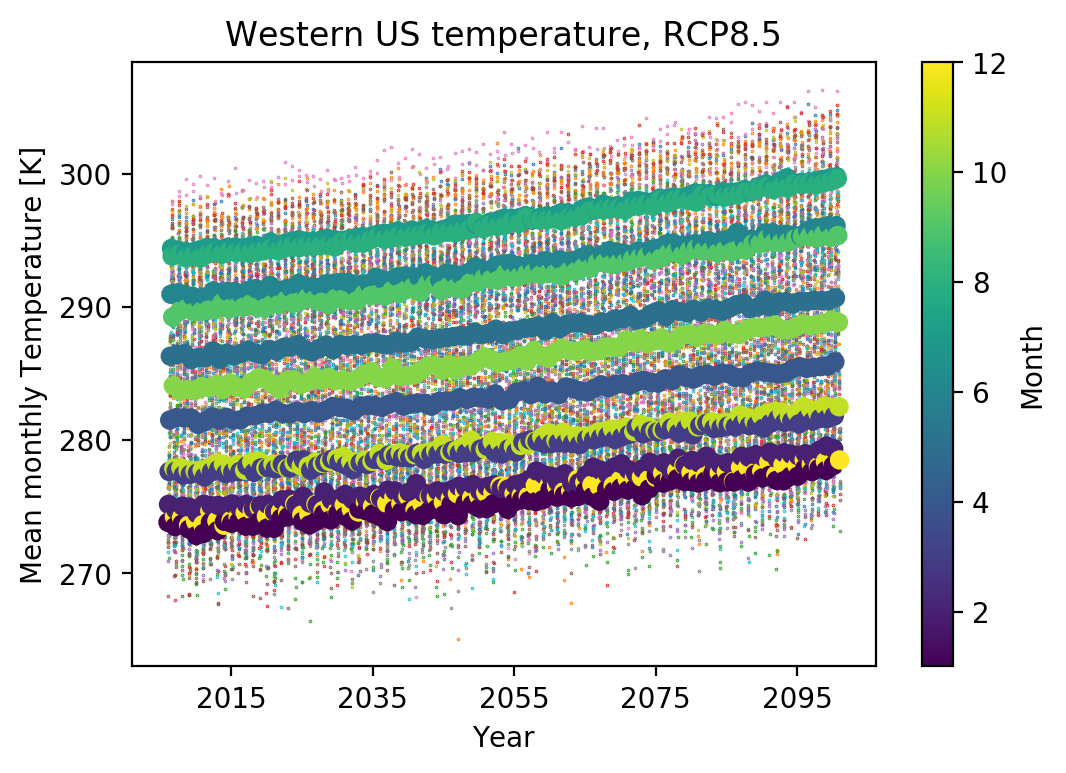

In [73]:
plt.figure(dpi=200)
for i in range(len(md.model_name.keys())):
    name = md.model_name.keys()[i]
    plt.scatter(t, df_tas_85[name], label = name, s=0.1, )
    
# Show the multimodel mean
plt.scatter(t, df_tas_85['mean'], c=df_tas_85["month"])
plt.colorbar(label="Month")
plt.ylabel("Mean monthly Temperature [K]")
plt.xlabel("Year")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Western US temperature, RCP8.5")
plt.show()

## Now I would like to look at just July, for both RCP4.5 and RCP8.5 together. 

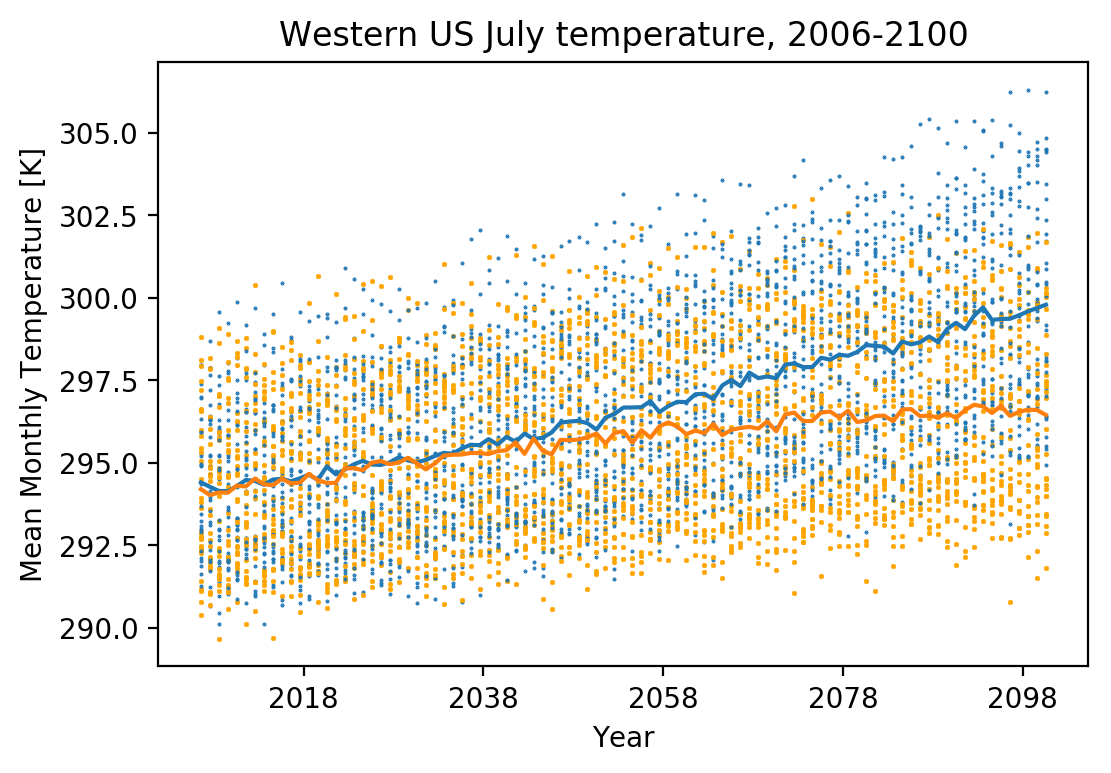

In [74]:
# TODO: Color code individual model institutions (similar models) by similar colors 
# TODO: Lots of different ways to display the spread shown in the below plot. 
mask = (df_tas_85.month == 7) #& (df.month <= 9)
plt.figure(dpi=200)

for model in md.model_name.keys():
    plt.scatter(t[mask], df_tas_85[model][mask], s=0.2, marker="o", c="#1f77b4")
    plt.scatter(t[mask], df_tas_45[model][mask], s=0.2, marker="s", c="orange")
    
    
plt.plot(t[mask], df_tas_85["mean"][mask], label="RCP 8.5 mean")
plt.plot(t[mask], df_tas_45["mean"][mask], label="RCP 4.5 mean")
#plt.legend()
plt.xlabel("Year")
plt.ylabel("Mean Monthly Temperature [K]")
plt.title("Western US July temperature, 2006-2100")
plt.show()

### These plots are a bit messy and lack context. Lets try making a plot that shows boxplots for different months for a couple of different decades

In [75]:
def df_temporal_subset(df_t, var, rcp, monthsToKeep=[6,7,8], decadesToKeep=[2000,2020,2040,2060,2080]):
    """Takes a time series pd.DataFrame and returns a plot ready DataFrame.
    Temporally subset a dataframe with columns 'month' and 'year'. This function
    will also add columns of deced and decadeLabel."""
    
    # First melt the dataframe that has temporal rows and model columns 
    df = pd.melt(df_t, id_vars=["year", "month"], value_vars=md.model_name.keys())
    df.columns = ["year", "month", "model", var]
    df['RCP'] = rcp
        
    # Assign a decade to each year. Good way to group data. 
    decade = df.year.astype(int) // 10 * 10 # int division // gives decade
    df['decade']= decade
    # Create a nice decade label 
    s1 = np.char.array(decade)
    s2 = np.chararray((len(s1)))
    s2[:] = "-"
    s3 = np.char.array(decade+9)
    df['decadeLabel'] =  s1 + s2 + s3

    # Now subset the dataframe to retain summer months only 
    monthMask = np.where(df['month'].isin(monthsToKeep))
    df_months = df.iloc[monthMask]
    
    # The decades of interest subset 
    decadeMask = np.where(df_months['decade'].isin(decadesToKeep))
    df_subset = df_months.iloc[decadeMask]
    
    return df_subset 


df_tas_85_plot = df_temporal_subset(df_tas_85, 'tas', 'RCP8.5')
df_tas_45_plot = df_temporal_subset(df_tas_45, 'tas', 'RCP4.5')

df_pr_85_plot = df_temporal_subset(df_pr_85, 'pr', 'RCP8.5', monthsToKeep=[3,4,5,6,7,7,9,10])
df_pr_45_plot = df_temporal_subset(df_pr_45, 'pr', 'RCP4.5', monthsToKeep=[3,4,5,6,7,7,9,10])
    
# Near surface relative humidity
df_hurs_85_plot = df_temporal_subset(df_hurs_85, 'hurs', 'RCP8.5')
df_hurs_45_plot = df_temporal_subset(df_hurs_45, 'hurs', 'RCP4.5')

# Near surface wind speed 
df_sfcWind_85_plot = df_temporal_subset(df_sfcWind_85, 'sfcWind', 'RCP8.5')
df_sfcWind_45_plot = df_temporal_subset(df_sfcWind_45, 'sfcWind', 'RCP4.5')

# TODO: The other variables that are relevant to PET
# TODO: VPD
# TODO: Different regions within the US. 

# Combine the dataframes using pd.concat, use tas as a test case 
frames = [df_tas_85_plot, df_tas_45_plot]
df_tas_both = pd.concat(frames)

In [76]:
df_tas_85_plot

,year,month,model,tas,RCP,decade,decadeLabel
5,2006,6,ACCESS1-0,294.032349,RCP8.5,2000,2000-2009
6,2006,7,ACCESS1-0,296.635040,RCP8.5,2000,2000-2009
7,2006,8,ACCESS1-0,296.157745,RCP8.5,2000,2000-2009
17,2007,6,ACCESS1-0,294.015167,RCP8.5,2000,2000-2009
18,2007,7,ACCESS1-0,296.757263,RCP8.5,2000,2000-2009
19,2007,8,ACCESS1-0,296.894958,RCP8.5,2000,2000-2009
29,2008,6,ACCESS1-0,294.779968,RCP8.5,2000,2000-2009
30,2008,7,ACCESS1-0,296.770386,RCP8.5,2000,2000-2009
31,2008,8,ACCESS1-0,296.503601,RCP8.5,2000,2000-2009
41,2009,6,ACCESS1-0,293.249512,RCP8.5,2000,2000-2009


### Plot all western US temporal spread for chosen months, decades, and all available models

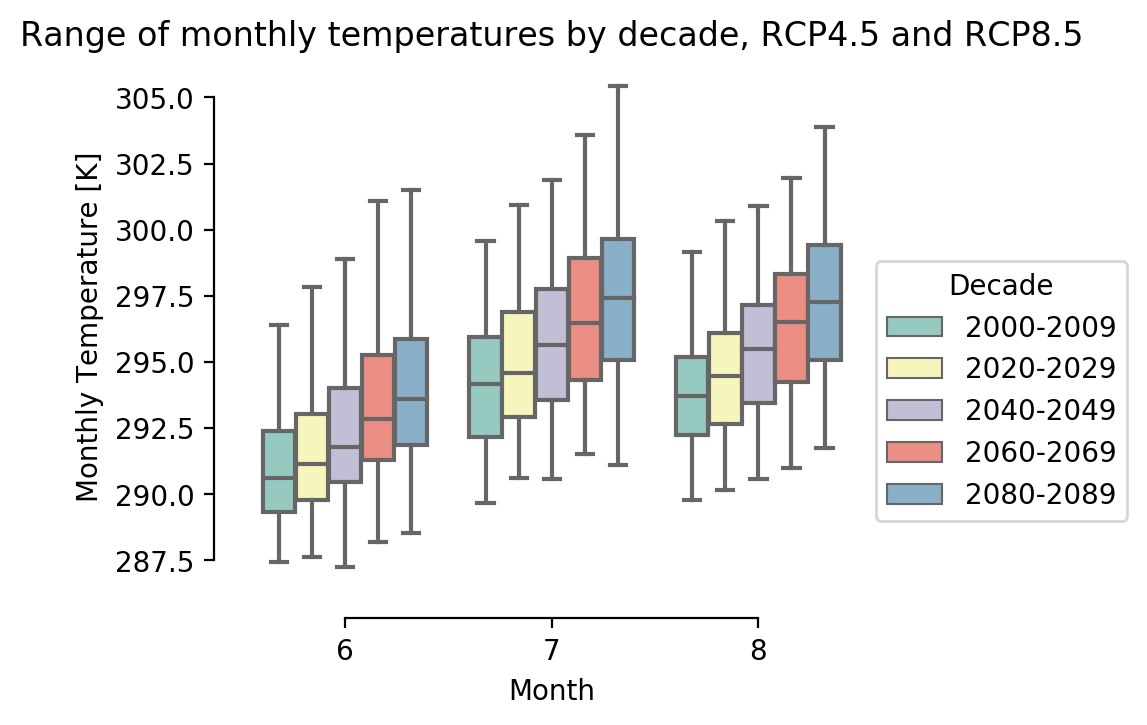

In [77]:
import seaborn as sns

plt.figure(dpi=200, figsize=(4,3.5))
ax = sns.boxplot(x="month", y="tas", hue="decadeLabel", data=df_tas_both, palette="Set3")
ax.legend( bbox_to_anchor=(1,0.65), title="Decade")
sns.despine() # gets rid of non-nessisary lines
sns.despine(offset=10, trim=True)
ax.set(xlabel='Month', ylabel='Monthly Temperature [K]')
ax.set(title="Range of monthly temperatures by decade, RCP4.5 and RCP8.5")
plt.show()

### Now seperate these distributions by RCP 4.5 and 8.5

In [80]:
def wrap_rcp_boxplot(df_45, df_85, yVar, yLab, regionName=""):
    """Temporary function for creating boxplots of spatially summarized data
    
    # TODO: Show individual datapoints from each model and have a color map for modeleling center. 
    # TODO: At the very least, show how many models were used in the calculation, since it changes. 
    # TODO: "Reference" decade to be added to ALL of these dataframes. This will be roughly 1980-2015 data. """
    
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, squeeze=False, dpi=250, figsize=(8,3.5))
    left_ax = axes[0][0]
    right_ax = axes[0][1]
    plt.subplots_adjust(wspace=0, hspace=0)

    # Create the left, usuallu RCP4.5 side of the figure
    ax1 = sns.boxplot(x="month", y=yVar, hue="decadeLabel", data=df_45, palette="Set3", ax=left_ax)
    ax1.legend_.remove()
    ax1.set(xlabel='Month', ylabel=yLab, title="RCP4.5" + " " + regionName)

    # Create the right, usually RCP8.5 side of the figure
    ax2 = sns.boxplot(x="month", y=yVar, hue="decadeLabel", data=df_85, palette="Set3", ax=right_ax)
    ax2.set(xlabel='Month', ylabel='', title="RCP8.5" + " " + regionName)
    ax2.legend( bbox_to_anchor=(1.,0.75), title="Decade")

    sns.despine() # gets rid of non-nessisary lines
    sns.despine(offset=10, trim=True)
    ax2.spines['left'].set_visible(False) # Specifically remove the right plots left spine 
    ax2.tick_params(bottom=True, left=False)

    plt.show()

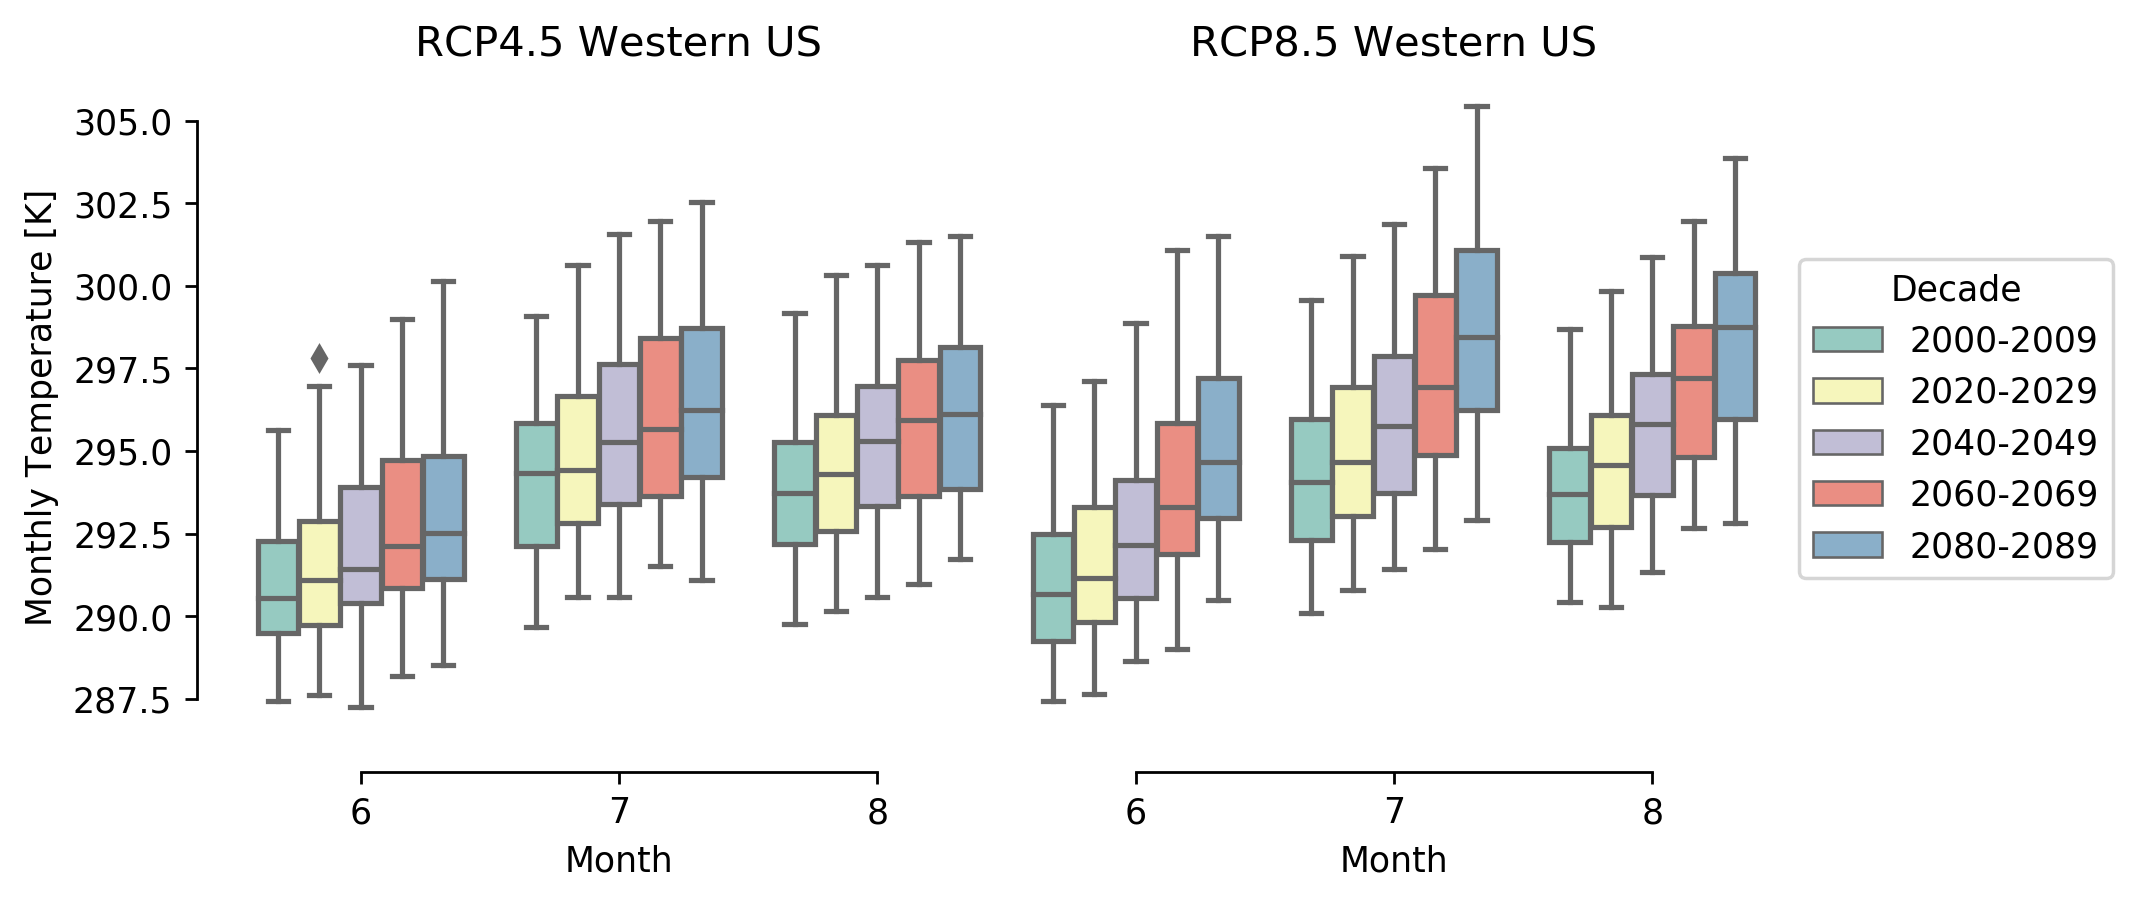

In [84]:
wrap_rcp_boxplot(df_tas_45_plot, df_tas_85_plot, "tas", 'Monthly Temperature [K]', "Western US")

## Streamline the way the dataframes needed for these types of boxplots are created. 
This will be needed when different regions are used. 

In [644]:
def make_boxplot_df(var, regions, regionName):
    """Executers the two functions needed for creating the dataframe structure needed for boxplots."""
    # Create plotting dataframe 85
    df_t_85 = make_var_df(var=var, rcp="85", regions=regions, regionName=regionName)
    df_t_85_plot = df_temporal_subset(df_t_85, var, 'RCP8.5', decadesToKeep=decadesToKeep)
    # Create plotting dataframe 45
    df_t_45 = make_var_df(var=var, rcp="45", regions=regions, regionName=regionName)
    df_t_45_plot = df_temporal_subset(df_t_45, var, 'RCP4.5', decadesToKeep=decadesToKeep)

    return df_t_45_plot, df_t_85_plot

Using region dictionary for bounds
---------------------------------------------
tas Dataframe for rcp85 complete.
---------------------------------------------
Using region dictionary for bounds
---------------------------------------------
tas Dataframe for rcp45 complete.
---------------------------------------------


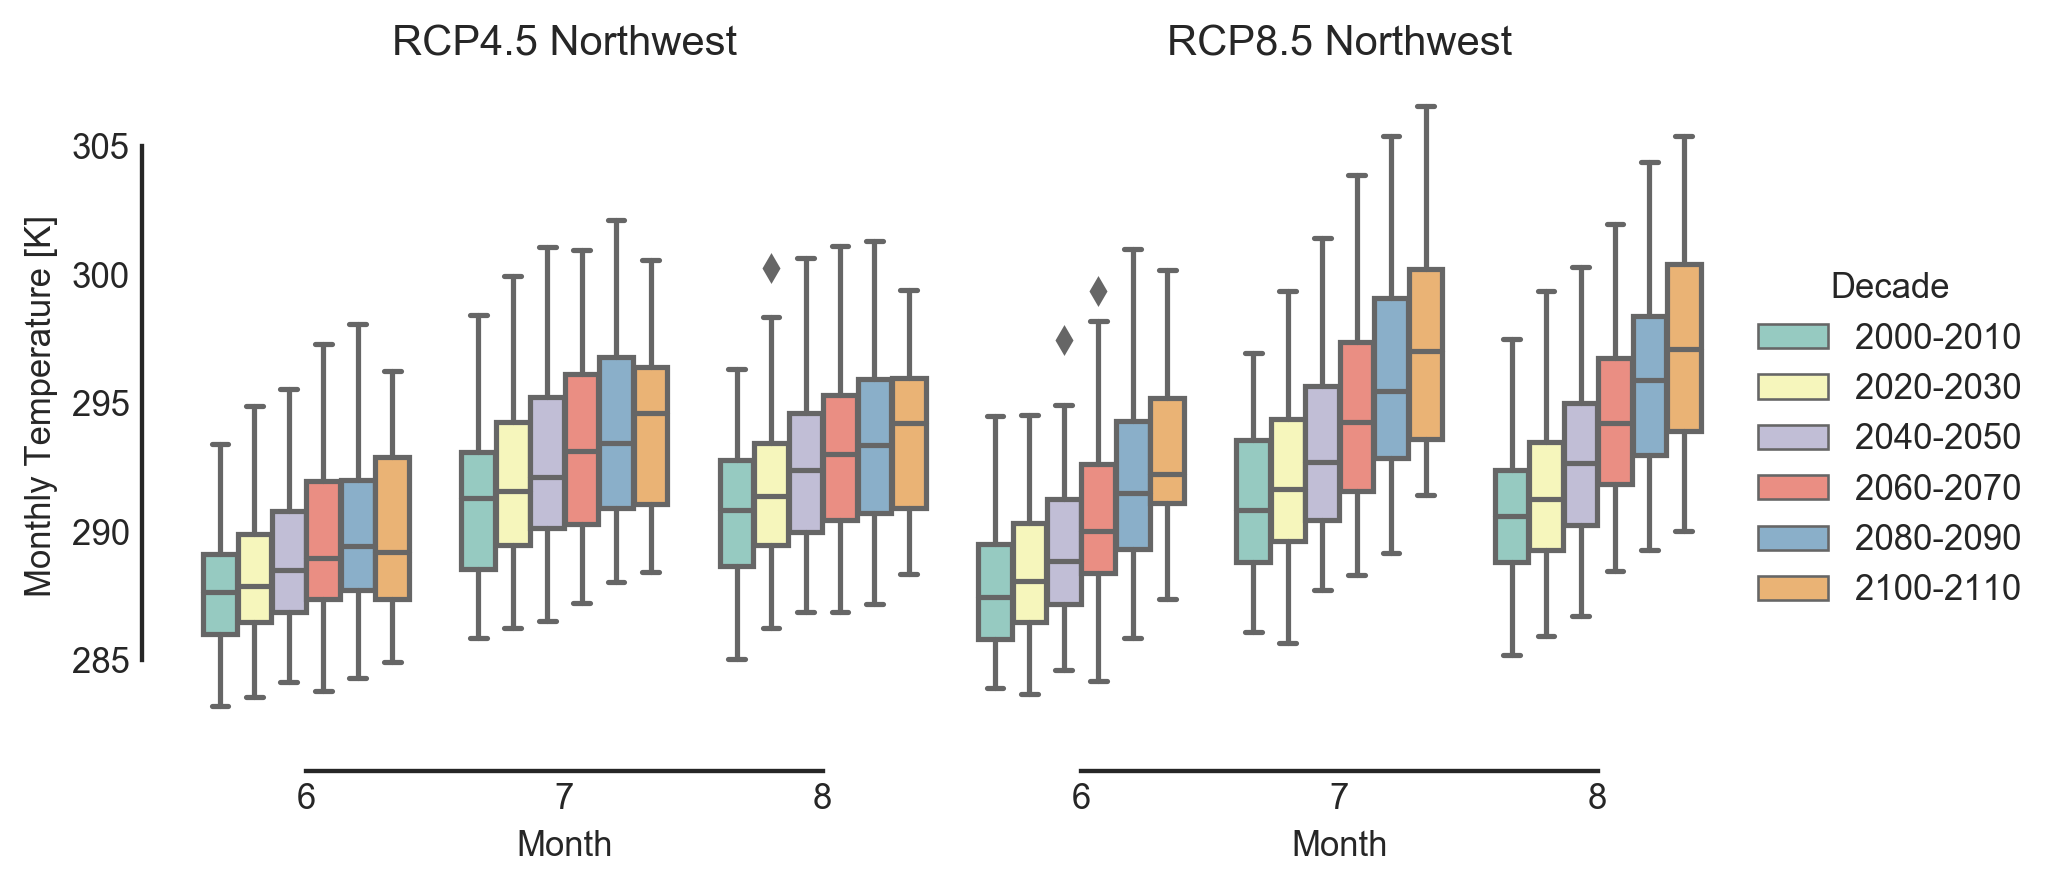

In [645]:
df_tas_45_NW_plot, df_tas_85_NW_plot = make_boxplot_df("tas", regions, "Northwest")
wrap_rcp_boxplot(df_tas_45_NW_plot, df_tas_85_NW_plot, "tas", 'Monthly Temperature [K]', "Northwest")

Using region dictionary for bounds
---------------------------------------------
tas Dataframe for rcp85 complete.
---------------------------------------------
Using region dictionary for bounds
---------------------------------------------
tas Dataframe for rcp45 complete.
---------------------------------------------


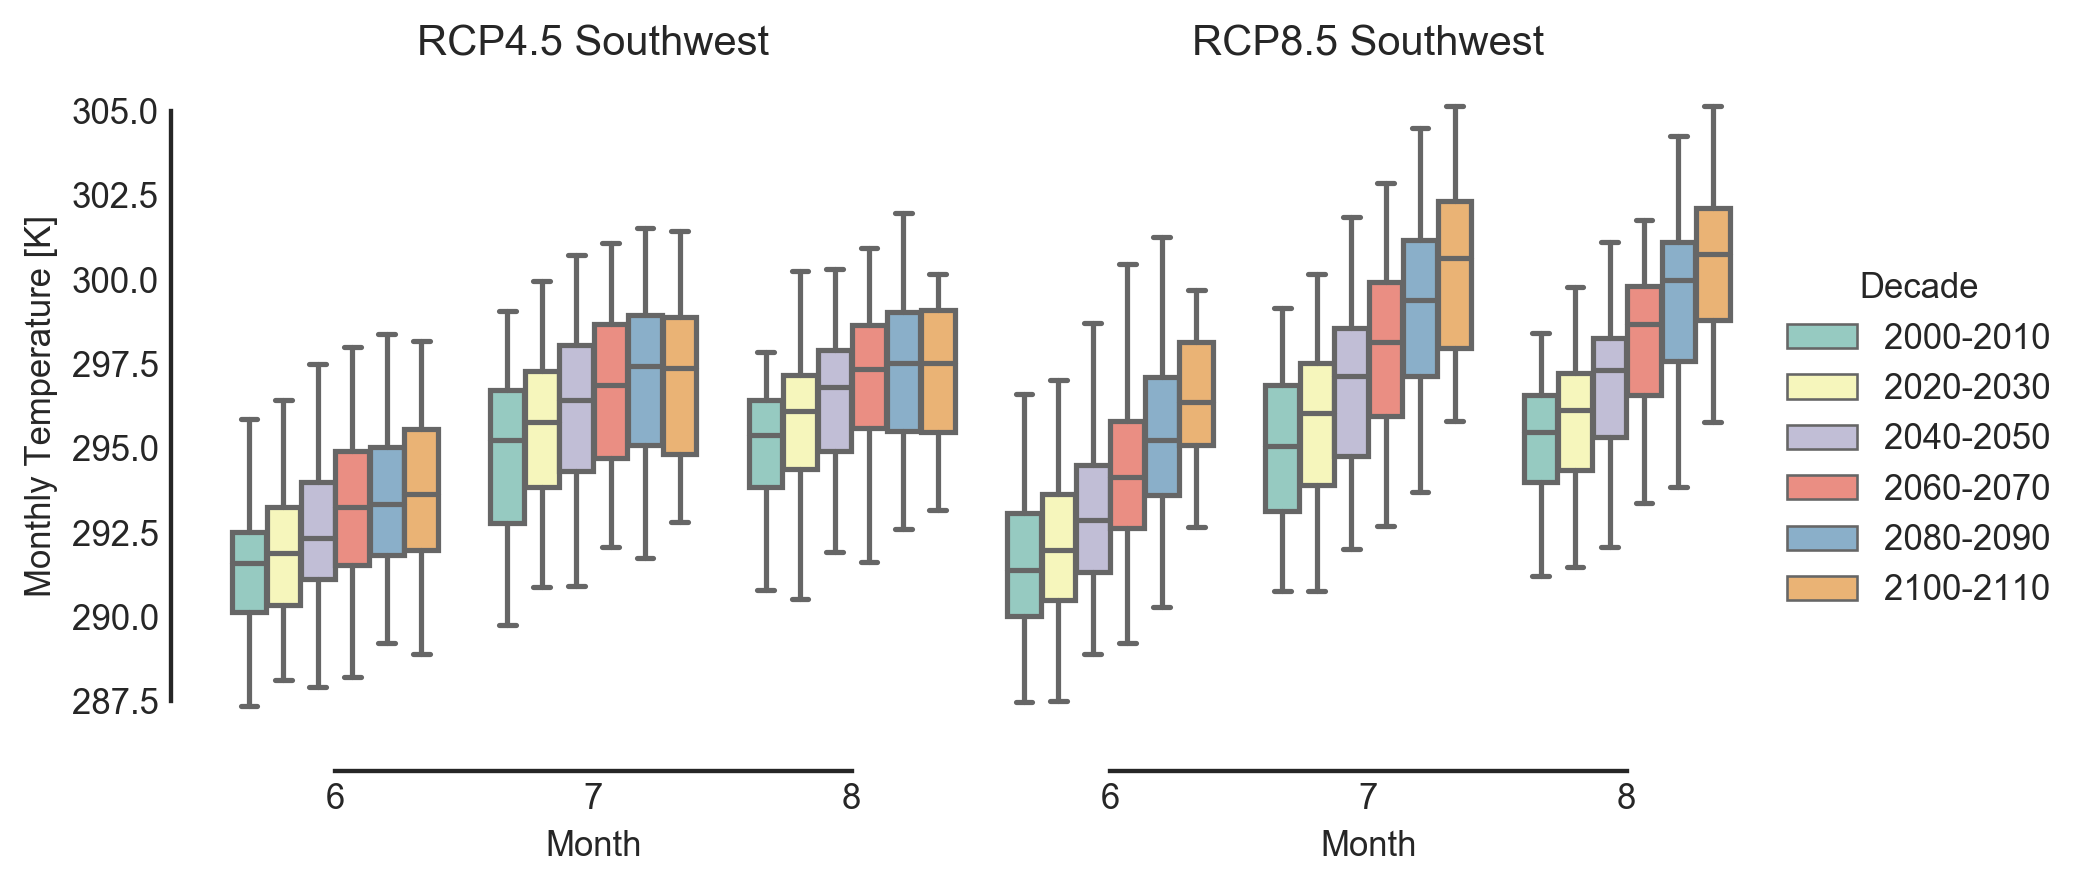

In [646]:
df_tas_45_SW_plot, df_tas_85_SW_plot = make_boxplot_df("tas", regions, "Southwest")
wrap_rcp_boxplot(df_tas_45_SW_plot, df_tas_85_SW_plot, "tas", 'Monthly Temperature [K]', "Southwest")

In [ ]:
# Create Central rockies plotting dataframe 85
df_tas_85_SW = make_var_df(var="tas", rcp="85", regions=regions, regionName="Southwest")
df_tas_85_SW_plot = df_temporal_subset(df_tas_85_SW, 'tas', 'RCP8.5', decadesToKeep=decadesToKeep)
# Create NW plotting dataframe 45
df_tas_45_SW = make_var_df(var="tas", rcp="45", regions=regions, regionName="Southwest")
df_tas_45_SW_plot = df_temporal_subset(df_tas_45_SW, 'tas', 'RCP4.5', decadesToKeep=decadesToKeep)

wrap_rcp_boxplot(df_tas_45_SW_plot, df_tas_85_SW_plot, "tas", 'Monthly Temperature [K]', "Southwest")

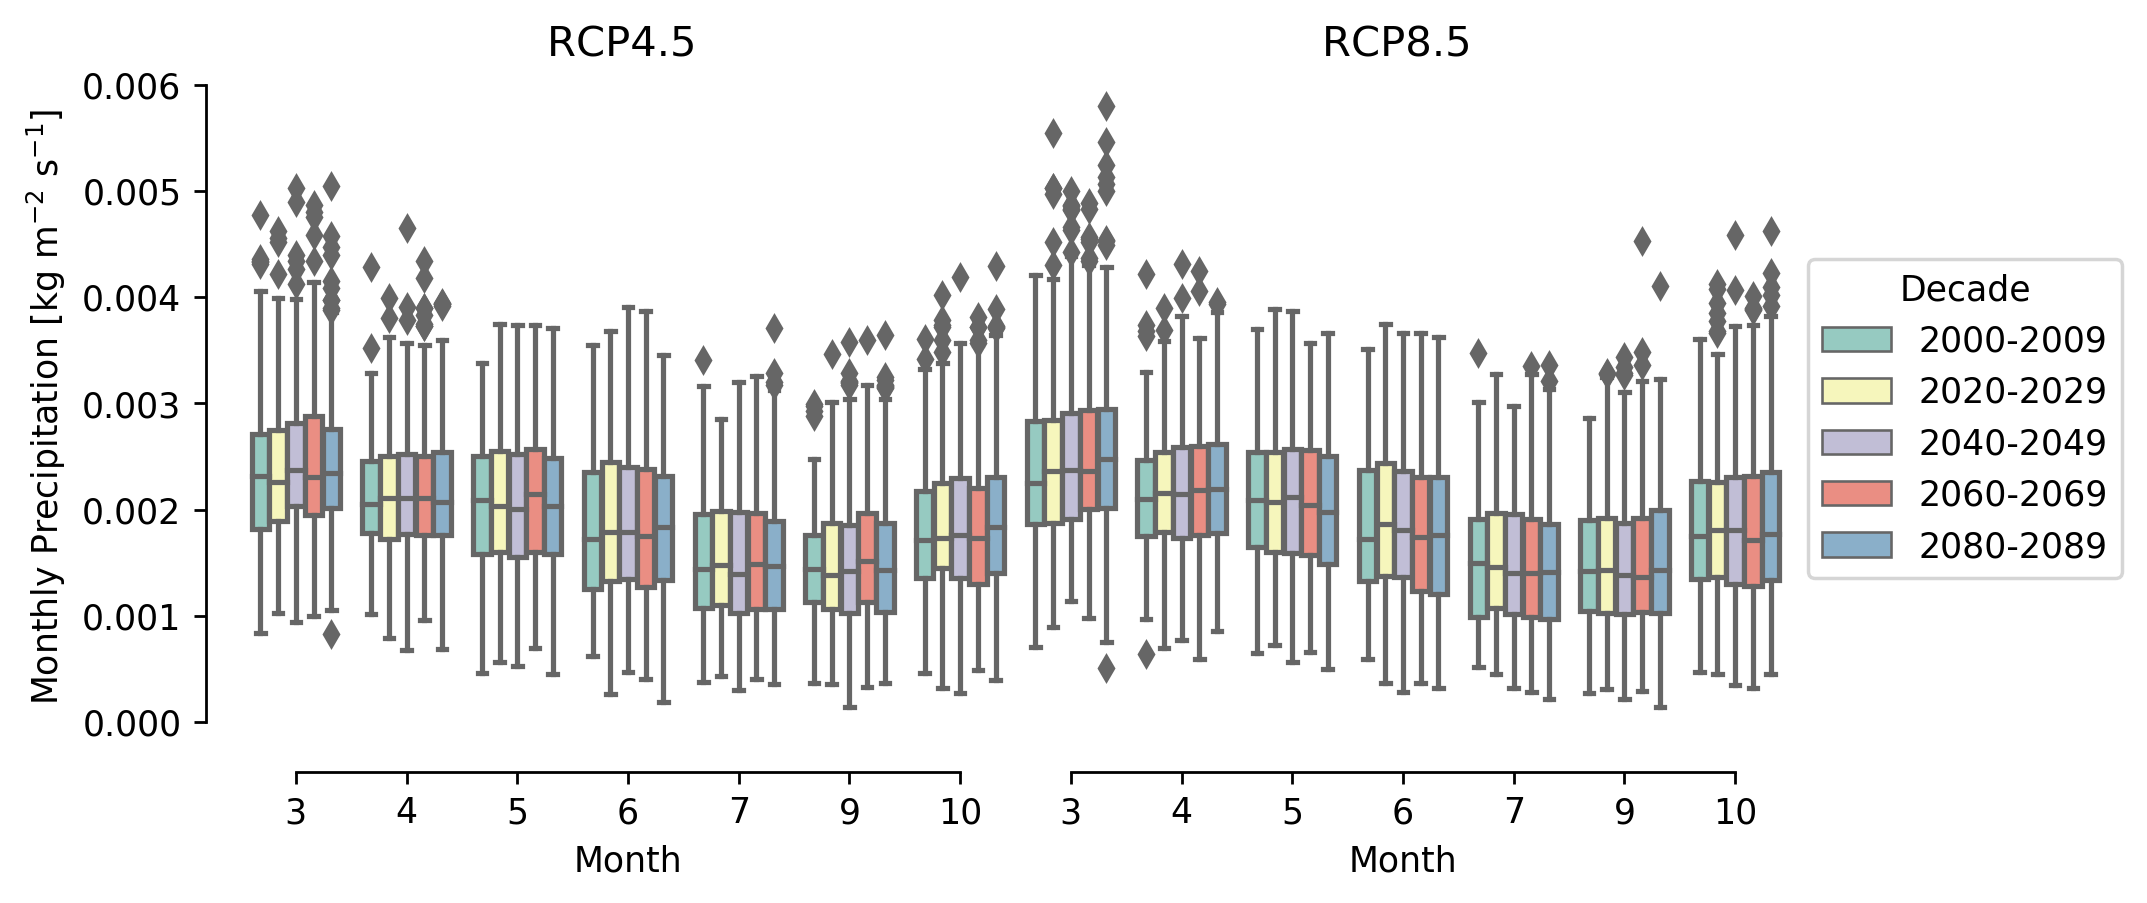

In [85]:
wrap_rcp_boxplot(df_pr_45_plot, df_pr_85_plot, "pr", 'Monthly Precipitation [kg m$^{-2}$ s$^{-1}$]')

Very hard to see any patters in precipitation at this scale. Looks like June might be getting a little drier in RCP8.5? That could matter compared to say, August, since June precip could determine how arid things are going into the summer and what kinds of moisture-limited ladder fuels are able to grow in late spring. There is a massive area being averaged for these plots. It is possible that outliers/patterns/trends are being driven by acute areas. This is why it is important that these plots be made for different sub-regions within the western US. 

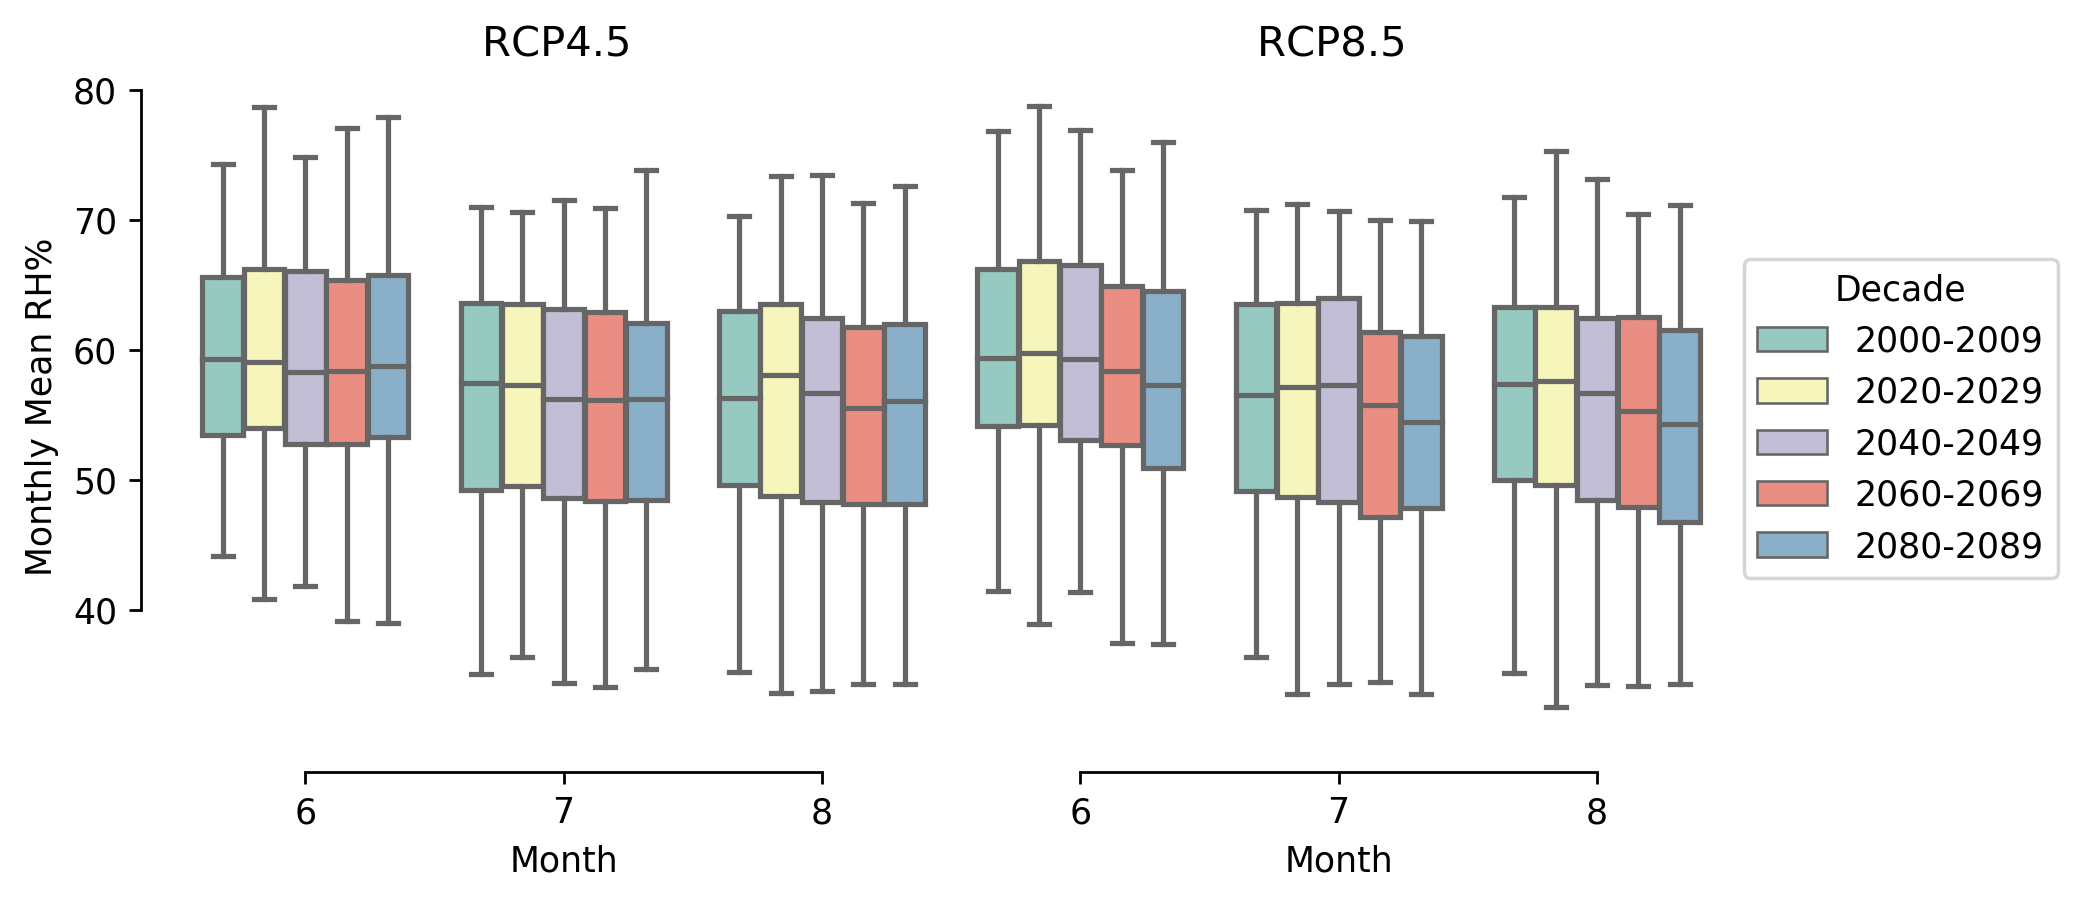

In [86]:
wrap_rcp_boxplot(df_hurs_45_plot, df_hurs_85_plot, "hurs", 'Monthly Mean RH%')

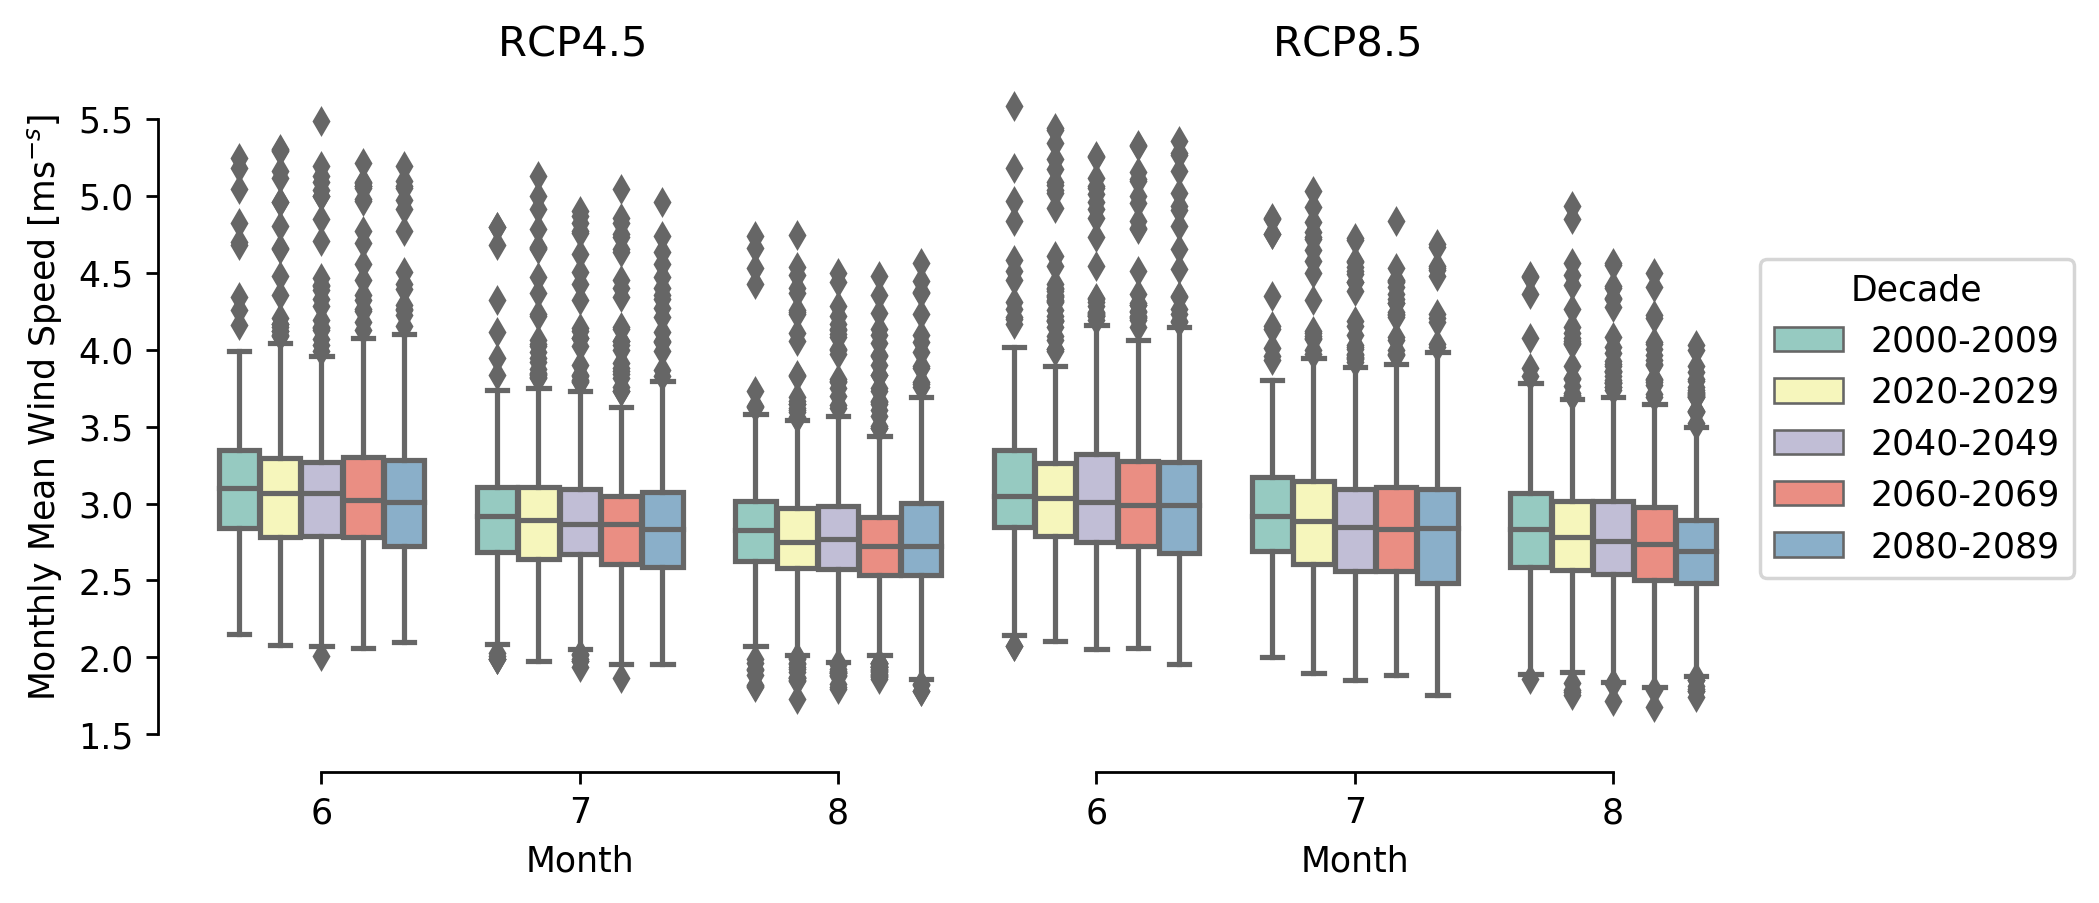

In [87]:
wrap_rcp_boxplot(df_sfcWind_45_plot, df_sfcWind_85_plot, "sfcWind", 'Monthly Mean Wind Speed [ms$^{-s}$]')

The next thing to look at is the change in the median value from the reference period (~ 1980-2015) for each of these distributions. The median value is what will be driving the signal in the regressions. Also, think of a good way to visualize the spread in each of the above distributions. 

d1 = np.linspace(1,10)
d2 = np.linspace(11,20)
d3 = np.linspace(21,30)
l = [d1, d2, d3]
#print(l)
ggplot(dd, aes(x='year', y='tas', col='model')) + geom_point() #+ theme_bw() #+ facet_wrap('~model')

Start too focus on difference between base state and future state for a given variable. Maybe do this in a spatial way. 